## Ladataan kirjastot

In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import glob
import time
import pickle
import sys
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")
randomState = 42

## Ladataan dataa

In [42]:
weatherData = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/cleaned_weather_hourly.csv')
weatherData.describe()
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21003 entries, 0 to 21002
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visibility           21003 non-null  float64
 1   windBearing          21003 non-null  int64  
 2   temperature          21003 non-null  float64
 3   time                 21003 non-null  object 
 4   dewPoint             21003 non-null  float64
 5   pressure             21003 non-null  float64
 6   apparentTemperature  21003 non-null  float64
 7   windSpeed            21003 non-null  float64
 8   precipType           21003 non-null  object 
 9   icon                 21003 non-null  object 
 10  humidity             21003 non-null  float64
 11  summary              21003 non-null  object 
 12  windChillEffect      21003 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 2.1+ MB


In [43]:
d = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/cleaned_halfhourly_data.csv')
d.describe()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   tstp            object 
 2   energy(kWh/hh)  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ GB


In [44]:
weatherData = weatherData.astype({'precipType':'string', 'icon':'string', 'summary':'string'})
weatherData['time'] = pd.to_datetime(weatherData['time'], errors='coerce')

In [12]:
# Valitsin säätietojen ominaisuudet ja lajittelin ajan mukaan, jotta voin käyttää niitä mallinnuksessa.
weatherUpsample = weatherData[['time','temperature', 'dewPoint']].copy()
weatherUpsample = weatherUpsample.sort_values(by=['time'])
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

<class 'pandas.core.frame.DataFrame'>
Index: 21003 entries, 312 to 20114
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         21003 non-null  datetime64[ns]
 1   temperature  21003 non-null  float64       
 2   dewPoint     21003 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 656.3 KB
None
                                time   temperature      dewPoint
count                          21003  21003.000000  21003.000000
mean   2013-01-14 12:37:54.532209664     10.340575      6.475615
min              2011-11-01 00:00:00     -5.160000     -9.980000
25%              2012-06-06 20:30:00      6.445000      2.810000
50%              2013-01-14 03:00:00      9.870000      6.530000
75%              2013-08-24 17:30:00     14.190000     10.260000
max              2014-03-31 22:00:00     26.060000     18.880000
std                              NaN      5.597197      5.009810

In [13]:
# Muokkasin säätiedot 30 minuutin aikaväleille ja täytin puuttuvat arvot interpoloinnilla.

weatherUpsample.set_index('time', inplace=True)
weatherUpsample.index.rename('time', inplace=True)

start_time = time.time()
weatherUpsample = weatherUpsample.resample('30Min').mean()

weatherUpsample['temperature'] = weatherUpsample['temperature'].interpolate()
weatherUpsample['dewPoint'] = weatherUpsample['dewPoint'].interpolate()

print('%s seconds' % (time.time() - start_time))

weatherUpsample = weatherUpsample.reset_index(names='DateTime')
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

0.016045093536376953 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42333 entries, 0 to 42332
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     42333 non-null  datetime64[ns]
 1   temperature  42333 non-null  float64       
 2   dewPoint     42333 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 992.3 KB
None
                  DateTime   temperature      dewPoint
count                42333  42333.000000  42333.000000
mean   2013-01-14 23:00:00     10.451898      6.533999
min    2011-11-01 00:00:00     -5.160000     -9.980000
25%    2012-06-08 11:30:00      6.475000      2.830000
50%    2013-01-14 23:00:00      9.935000      6.580000
75%    2013-08-23 10:30:00     14.320000     10.330000
max    2014-03-31 22:00:00     26.060000     18.880000
std                    NaN      5.719442      5.039595
                 DateTime  temperature  dewPoint
0     20

In [14]:
weatherUpsample.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/WeatherDataFinal.csv',index=False)

In [15]:
weatherUpsample = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/WeatherDataFinal.csv')
weatherUpsample

,DateTime,temperature,dewPoint
0,2011-11-01 00:00:00,13.490,11.480
1,2011-11-01 00:30:00,13.110,11.530
2,2011-11-01 01:00:00,12.730,11.580
3,2011-11-01 01:30:00,13.190,11.860
4,2011-11-01 02:00:00,13.650,12.140
...,...,...,...
42328,2014-03-31 20:00:00,13.620,7.910
42329,2014-03-31 20:30:00,13.325,7.935
42330,2014-03-31 21:00:00,13.030,7.960
42331,2014-03-31 21:30:00,12.770,7.965


In [24]:
# Muunnan älymittarin käyttötietotyyppi floatiksi
start_time = time.time()
d.iloc[:, 2] = pd.to_numeric(d.iloc[:, 2], errors='coerce')
print('%s seconds' % (time.time() - start_time))

d.rename(columns={d.columns[2]: 'kWhPerHalfHour'}, inplace=True)
d.info()

0.0013248920440673828 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   LCLid           object 
 1   tstp            object 
 2   kWhPerHalfHour  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ GB


In [26]:
start_time = time.time()
d.set_index('tstp') # Asetan ajan indeksiksi
print('%s seconds' % (time.time() - start_time))

6.1942338943481445 seconds


- Tarkistetaan ja Poistetaan ne rivit, joissa aikaleimat eivät ole tarkalleen tasan puolen tunnin välein. Tämä varmistaa, että data on tasavälinen aikajaksojen suhteen jatkokäsittelyä varten.

In [31]:
d['tstp'] = pd.to_datetime(d['tstp'], errors='coerce')

start_time = time.time()

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
print('\nRecords not exactly on the half-hour:\n ', offRecs)
print(offRecs.info())

d.drop(offRecs.index, inplace=True)

print('%s seconds' % (time.time() - start_time))

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
print('\nRecords not exactly on the half-hour:\n ', offRecs)


Records not exactly on the half-hour:
                 LCLid                tstp  kWhPerHalfHour
18104      MAC000027 2012-12-18 15:13:41           0.117
52061      MAC000406 2012-12-18 15:15:33           0.117
85926      MAC000492 2012-12-18 15:15:43           0.117
119556     MAC000512 2012-12-18 15:15:45           0.117
137531     MAC000726 2012-12-18 15:16:42           0.117
...              ...                 ...             ...
167682099  MAC003747 2012-12-18 15:24:04           0.117
167710573  MAC004693 2012-12-18 15:22:47           0.117
167739106  MAC004709 2012-12-18 15:22:49           0.117
167772486  MAC004744 2012-12-18 15:15:51           0.117
167809899  MAC004883 2012-12-18 15:14:15           0.117

[5560 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 5560 entries, 18104 to 167809899
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   LCLid           5560 non-null  

- Luodaan puuttuvien aikaleimojen kohdalle NaN-arvot ja täyttää nämä arvot interpoloimalla, mikä takaa tasavälinen aikajaksojen analyysin. Tämä auttaa käsittelemään epätäydellistä dataa ja estää virheitä myöhemmissä laskelmissa.

In [ ]:
d['tstp'] = pd.to_datetime(d['tstp'], errors='coerce')
d.sort_values(by=['tstp'], inplace=True)
d.set_index('tstp', inplace=True)
d.index.rename('tstp', inplace=True)

start_time = time.time()
d = d.groupby('LCLid')\
                .resample('30Min')\
                .mean()

d['kWhPerHalfHour'] = d['kWhPerHalfHour'].interpolate(limit=2, limit_area='inside')
d.reset_index(inplace=True)

print('%s seconds' % (time.time() - start_time))

53.613757848739624 seconds


In [33]:
d.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/MeterDataFinal.csv',index=False)

262.22067403793335 seconds


- Tässä vaiheessa lasketaan kunkin aikaleiman yhteenlaskettu energiankulutus ja aktiivisten mittareiden määrä, mikä auttaa ymmärtämään yleisiä kulutustrendejä.

In [36]:
start_time = time.time()
aggLoad = pd.DataFrame(d.groupby('tstp')['kWhPerHalfHour'].agg({'sum', 'count'}))
aggLoad.reset_index(inplace=True)
aggLoad.columns = ['tstp', 'numMeters', 'AggregateLoad']
print('%s seconds' % (time.time() - start_time))

print(aggLoad)
print(aggLoad.describe())
print(aggLoad.info())

3.6844842433929443 seconds
                     tstp    numMeters  AggregateLoad
0     2011-11-23 09:00:00     0.569000              2
1     2011-11-23 09:30:00     0.561000              2
2     2011-11-23 10:00:00     0.920000              6
3     2011-11-23 10:30:00     0.588000              6
4     2011-11-23 11:00:00     0.772000              7
...                   ...          ...            ...
39722 2014-02-27 22:00:00  1494.829500           4987
39723 2014-02-27 22:30:00  1422.109001           4987
39724 2014-02-27 23:00:00  1258.090000           4987
39725 2014-02-27 23:30:00  1073.622001           4987
39726 2014-02-28 00:00:00  1042.266000           4987

[39727 rows x 3 columns]
                      tstp     numMeters  AggregateLoad
count                39727  39727.000000   39727.000000
mean   2013-01-10 04:30:00    894.773908    4224.970448
min    2011-11-23 09:00:00      0.561000       2.000000
25%    2012-06-17 06:45:00    531.521500    4082.000000
50%    2013-01-10 0

- Tässä datan aikaleimat järjestetään ja asetetaan indeksiksi analyysin helpottamiseksi.


In [37]:
aggLoad.sort_values(by=['tstp'], inplace=True)
aggLoad.set_index('tstp', inplace=True)
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   numMeters      39727 non-null  float64
 1   AggregateLoad  39727 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 931.1 KB


In [38]:
aggLoad['DateTime'] = aggLoad.index # Indeksi kopioidaan uudeksi sarakkeeksi nimellä "DateTime" jatkokäsittelyä varten.
aggLoad.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      39727 non-null  float64       
 1   AggregateLoad  39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


- Poistetaan, joiden ajankohdat eivät ole täsmälleen puolessa tunnissa, varmistaen yhtenäisyyden aikajaksoissa.


In [46]:
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:  Empty DataFrame
Columns: [numMeters, AggregateLoad, DateTime]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      0 non-null      float64       
 1   AggregateLoad  0 non-null      int64         
 2   DateTime       0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 0.0 bytes
None
Records not exactly on the half-hour:  Empty DataFrame
Columns: [numMeters, AggregateLoad, DateTime]
Index: []


- Lasketaan liukuva keskiarvo ja keskihajonta kaikkien mittarien kokonaiskulutukselle määritellyllä ikkuna ajalla. joka on 1/10 datan pituudesta. Tämä auttaa tunnistamaan kuormituksen vaihtelut ja trendit ajan kuluessa. Tulokset tallennetaan muuttujiin `aggLoadMovingStdev` ja `aggLoadMovingAvg`.

In [41]:
window_size = int(len(aggLoad.AggregateLoad) / 10)
print(window_size)

aggLoadMovingStdev = aggLoad.AggregateLoad.rolling(window_size).std()
aggLoadMovingStdev.columns = ['MovingStdev']

aggLoadMovingAvg = aggLoad.AggregateLoad.rolling(window_size).mean()
aggLoadMovingAvg.columns = ['MovingAvg']

print('aggLoadMovingStdev:\n', aggLoadMovingStdev)
print(aggLoadMovingStdev.info())
print('aggLoadMovingAvg:\n', aggLoadMovingAvg)
print(aggLoadMovingAvg.info())

3972
aggLoadMovingStdev:
 DateTimeIndex
2011-11-23 09:00:00          NaN
2011-11-23 09:30:00          NaN
2011-11-23 10:00:00          NaN
2011-11-23 10:30:00          NaN
2011-11-23 11:00:00          NaN
                         ...    
2014-02-27 22:00:00    71.487800
2014-02-27 22:30:00    71.490455
2014-02-27 23:00:00    71.493096
2014-02-27 23:30:00    71.495722
2014-02-28 00:00:00    71.498333
Name: AggregateLoad, Length: 39727, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
35756 non-null  float64
dtypes: float64(1)
memory usage: 620.7 KB
None
aggLoadMovingAvg:
 DateTimeIndex
2011-11-23 09:00:00            NaN
2011-11-23 09:30:00            NaN
2011-11-23 10:00:00            NaN
2011-11-23 10:30:00            NaN
2011-11-23 11:00:00            NaN
                          ...     
2014-02-27 22:00:00    5057.360272
2014-02-27 22

In [48]:
aggLoad.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/aggLoadDataFinal.csv',index=False)

In [49]:
aggLoad = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/aggLoadDataFinal.csv', parse_dates=["DateTime"])
aggLoad

,numMeters,AggregateLoad,DateTime
0,0.569000,2,2011-11-23 09:00:00
1,0.561000,2,2011-11-23 09:30:00
2,0.920000,6,2011-11-23 10:00:00
3,0.588000,6,2011-11-23 10:30:00
4,0.772000,7,2011-11-23 11:00:00
...,...,...,...
39722,1494.829500,4987,2014-02-27 22:00:00
39723,1422.109001,4987,2014-02-27 22:30:00
39724,1258.090000,4987,2014-02-27 23:00:00
39725,1073.622001,4987,2014-02-27 23:30:00


- Liitän säätiedot ja älymittarin käyttötiedot yhteen


In [51]:
aggLoad['DateTime'] = pd.to_datetime(aggLoad['DateTime'])
weatherUpsample['DateTime'] = pd.to_datetime(weatherUpsample['DateTime'])

mergeData = pd.merge(aggLoad, weatherUpsample, on='DateTime', copy=False)
print(mergeData.info())
mergeData


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      39727 non-null  float64       
 1   AggregateLoad  39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB
None


,numMeters,AggregateLoad,DateTime,temperature,dewPoint
0,0.569000,2,2011-11-23 09:00:00,4.840,4.680
1,0.561000,2,2011-11-23 09:30:00,5.290,5.070
2,0.920000,6,2011-11-23 10:00:00,5.740,5.460
3,0.588000,6,2011-11-23 10:30:00,6.705,5.600
4,0.772000,7,2011-11-23 11:00:00,7.670,5.740
...,...,...,...,...,...
39722,1494.829500,4987,2014-02-27 22:00:00,4.100,1.640
39723,1422.109001,4987,2014-02-27 22:30:00,4.015,1.625
39724,1258.090000,4987,2014-02-27 23:00:00,3.930,1.610
39725,1073.622001,4987,2014-02-27 23:30:00,3.870,1.570


Lisään ajankohtaan liittyviä ominaisuuksia, kuten viikonpäivän ja vuorokauden ajan, jotka auttavat mallia ymmärtämään kausiluonteisia ja säännöllisiä trendejä. Näitä ominaisuuksia käsitellään sinin ja kosinin avulla, jotta mallille voidaan esittää syklisiä tietoja tehokkaammin.

In [53]:

print(mergeData.info())
# viikonpäivä ja vuodenaika kategorisina muuttujina sin ja cos muodossa
weekOfYear = mergeData.DateTime.dt.isocalendar().week
mergeData["weekOfYear_sin"] = np.sin(weekOfYear * (2. * np.pi / 52))
mergeData["weekOfYear_cos"] = np.cos(weekOfYear * (2. * np.pi / 52))

# päivä viikossa kategorisena muuttujana sin ja cos muodossa
dayOfWeek = mergeData.DateTime.dt.dayofweek
mergeData["dayOfWeek_sin"] = np.sin(dayOfWeek * (2. * np.pi / 7))
mergeData["dayOfWeek_cos"] = np.cos(dayOfWeek * (2. * np.pi / 7))

# minuutti päivästä kategorisena muuttujana sin ja cos muodossa
minuteOfDay = (mergeData.DateTime.dt.hour * 60) + mergeData.DateTime.dt.minute
mergeData["minuteOfDay_sin"] = np.sin(minuteOfDay * (2. * np.pi / 48))
mergeData["minuteOfDay_cos"] = np.cos(minuteOfDay * (2. * np.pi / 48))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   numMeters      39727 non-null  float64       
 1   AggregateLoad  39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 MB
None


- Tässä vaiheessa AggregateLoad arvoja asetetaan aikaleimaindeksiin, jotta ne ovat helpommin analysoitavissa ja käytettävissä ajan sarjojen analysoinnissa. Tämä on hyödyllistä, jos tavoitteena on tarkastella kuormituksen aikavaihteluita tai suorittaa ennustemalleja.


In [54]:
decomp_df = pd.DataFrame(mergeData.copy())
decomp_df = decomp_df.set_index(pd.DatetimeIndex(decomp_df['DateTime']))
decomp_df.index=decomp_df.DateTime
decomp_df = decomp_df.AggregateLoad
print(decomp_df.describe())
print(decomp_df.info)

count    39727.000000
mean      4224.970448
std       1789.290602
min          2.000000
25%       4082.000000
50%       5127.000000
75%       5361.000000
max       5532.000000
Name: AggregateLoad, dtype: float64
<bound method Series.info of DateTime
2011-11-23 09:00:00       2
2011-11-23 09:30:00       2
2011-11-23 10:00:00       6
2011-11-23 10:30:00       6
2011-11-23 11:00:00       7
                       ... 
2014-02-27 22:00:00    4987
2014-02-27 22:30:00    4987
2014-02-27 23:00:00    4987
2014-02-27 23:30:00    4987
2014-02-28 00:00:00    4987
Name: AggregateLoad, Length: 39727, dtype: int64>


In [57]:
%matplotlib inline

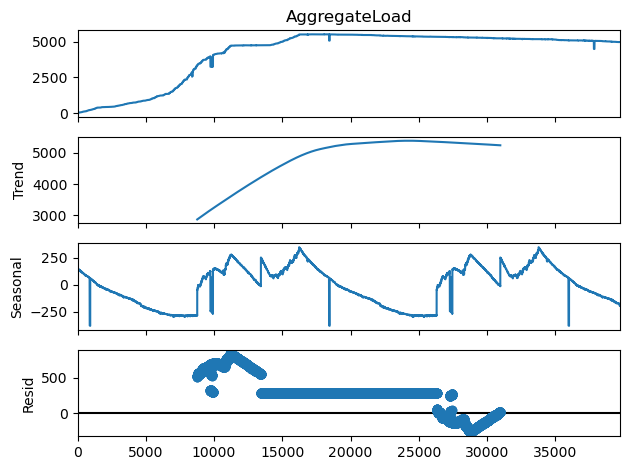

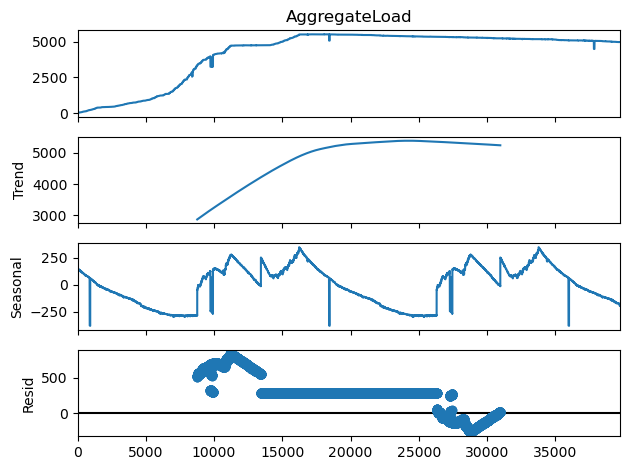

In [59]:
# Tarkistan aikasarjan trendin ja kausivaihtelun vuositasolla 
from statsmodels.tsa.seasonal import seasonal_decompose
yearly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=17532)
mergeData['yearlySeasonal']=yearly_seasonal_decomp.seasonal
yearly_seasonal_decomp.plot()

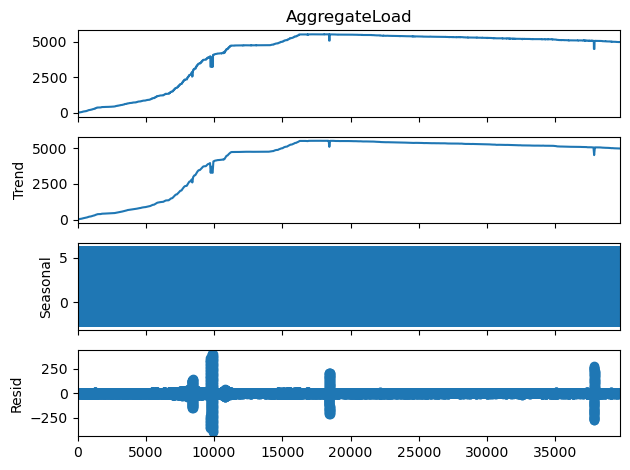

In [60]:
# päivittäinen kausivaihtelu ja trendi 
from statsmodels.tsa.seasonal import seasonal_decompose
daily_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=48)
mergeData['dailyTrend']=daily_seasonal_decomp.trend
mergeData['dailySeasonal']=daily_seasonal_decomp.seasonal
mergeData['dailyResid']=daily_seasonal_decomp.resid
daily_seasonal_decomp.plot();

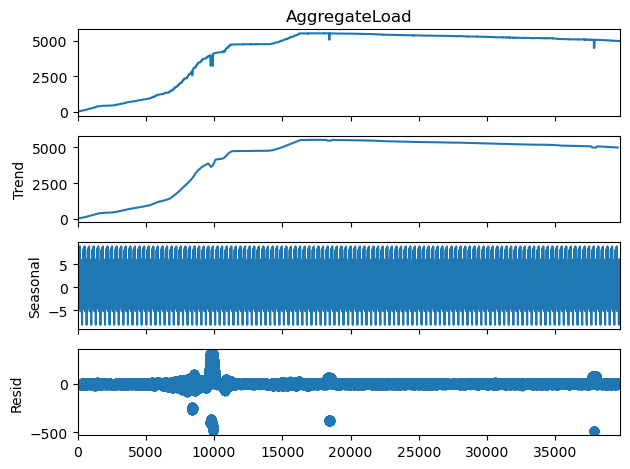

In [61]:
# viikottainen kausivaihtelu ja trendi 
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=336)
mergeData['weeklyTrend']=weekly_seasonal_decomp.trend
mergeData['weeklySeasonal']=weekly_seasonal_decomp.seasonal
mergeData['weeklyResid']=weekly_seasonal_decomp.resid
weekly_seasonal_decomp.plot();

- Tässä vaiheessa lisätään kuorman 1 päivän ja 1 viikon viivästetyt arvot (lag) sekä kuorman muutokset viimeisen puolen tunnin ja viikon takaiseen arvoon. Nämä ominaisuudet auttavat mallia tunnistamaan ajalliset trendit ja kausivaihtelut energian käytössä.


In [62]:
# latasin yhden päivän lagin ja yhden viikon lagin. lag on aikaväli, joka on siirtynyt aikasarjassa.
oneDayPeriods = 48
mergeData['AggregateLoad_1dayLag'] = mergeData['AggregateLoad'].shift(oneDayPeriods)
oneWeekPeriods = oneDayPeriods * 7
mergeData['AggregateLoad_1weekLag'] = mergeData['AggregateLoad'].shift(oneWeekPeriods)

mergeData['AggregateLoad_halfhourdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(1)
mergeData['AggregateLoad_weekdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(oneWeekPeriods)

print(mergeData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   numMeters                   39727 non-null  float64       
 1   AggregateLoad               39727 non-null  int64         
 2   DateTime                    39727 non-null  datetime64[ns]
 3   temperature                 39727 non-null  float64       
 4   dewPoint                    39727 non-null  float64       
 5   weekOfYear_sin              39727 non-null  Float64       
 6   weekOfYear_cos              39727 non-null  Float64       
 7   dayOfWeek_sin               39727 non-null  float64       
 8   dayOfWeek_cos               39727 non-null  float64       
 9   minuteOfDay_sin             39727 non-null  float64       
 10  minuteOfDay_cos             39727 non-null  float64       
 11  yearlySeasonal              39727 non-null  float64   

- Tässä vaiheessa poistetaan puuttuvat arvot ja lisätään päivän maksimilämpötila (`temp_daymax`) sekä minimilämpötila (`temp_daymin`) jokaiselle päivälle. Tämä auttaa ymmärtämään lämpötilan vaikutusta energiankulutukseen päivän aikana.

In [63]:
mergeData.dropna(inplace=True)
mergeData['temp_daymax'] = mergeData.groupby(mergeData.DateTime.dt.date)['temperature'].transform('max')
mergeData['temp_daymin'] = mergeData.groupby(weatherUpsample.DateTime.dt.date)['temperature'].transform('min')
print(mergeData['temp_daymax'])
print(mergeData['temp_daymin'])

336      11.87
337      11.87
338      11.87
339      11.87
340      11.87
         ...  
39554    13.07
39555    13.07
39556    13.07
39557    13.07
39558    13.07
Name: temp_daymax, Length: 39223, dtype: float64
336      7.66
337      7.66
338      7.66
339      7.66
340      7.66
         ... 
39554    9.22
39555    9.22
39556    9.22
39557    9.22
39558    9.22
Name: temp_daymin, Length: 39223, dtype: float64


In [64]:
mergeData.drop(columns=['DateTime'], inplace=True)
mergeData.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/mergeDataFeatureCandidates.csv',index=False)
mergeData = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/mergeDataFeatureCandidates.csv')
mergeData


,numMeters,AggregateLoad,temperature,dewPoint,weekOfYear_sin,weekOfYear_cos,dayOfWeek_sin,dayOfWeek_cos,minuteOfDay_sin,minuteOfDay_cos,yearlySeasonal,dailyTrend,dailySeasonal,dailyResid,weeklyTrend,weeklySeasonal,weeklyResid,AggregateLoad_1dayLag,AggregateLoad_1weekLag,AggregateLoad_halfhourdiff,AggregateLoad_weekdiff,temp_daymax,temp_daymin
0,10.951000,64,7.660,4.960,-0.464723,0.885456,0.974928,-0.222521,1.000000e+00,9.790985e-16,115.191185,68.322917,-1.646815,-2.676102,70.956845,-6.805593,-0.151252,55.0,2.0,1.0,62.0,11.87,7.66
1,12.916000,66,8.695,5.475,-0.464723,0.885456,0.974928,-0.222521,-7.071068e-01,7.071068e-01,115.091995,68.593750,-1.197752,-1.395998,71.162202,-6.273427,1.111225,57.0,2.0,2.0,64.0,11.87,7.66
2,12.444000,69,9.730,5.990,-0.464723,0.885456,0.974928,-0.222521,1.371976e-14,-1.000000e+00,114.992862,68.864583,-0.748689,0.884106,71.367560,-5.561761,3.194202,57.0,6.0,3.0,63.0,11.87,7.66
3,12.323000,70,10.510,6.040,-0.464723,0.885456,0.974928,-0.222521,7.071068e-01,7.071068e-01,115.893672,69.135417,-0.380642,1.245225,71.572917,-5.217617,3.644700,58.0,6.0,1.0,64.0,11.87,7.66
4,10.693500,70,11.290,6.090,-0.464723,0.885456,0.974928,-0.222521,-1.000000e+00,-1.224956e-14,115.794425,69.406250,0.061166,0.532584,71.778274,-4.625610,2.847336,58.0,7.0,0.0,63.0,11.87,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39218,1038.973000,4993,11.320,6.260,0.885456,0.464723,0.000000,1.000000,1.371976e-14,-1.000000e+00,-170.094007,4992.875000,-0.748689,0.873689,4991.361607,0.054533,1.583860,4993.0,5004.0,0.0,-11.0,13.07,9.22
39219,1023.099833,4993,11.890,6.055,0.885456,0.464723,0.000000,1.000000,7.071068e-01,7.071068e-01,-170.121956,4992.875000,-0.380642,0.505642,4991.328869,0.607348,1.063783,4993.0,5004.0,0.0,-11.0,13.07,9.22
39220,996.079166,4993,12.460,5.850,0.885456,0.464723,0.000000,1.000000,-1.000000e+00,-1.224956e-14,-170.149905,4992.875000,0.061166,0.063834,4991.296131,1.185586,0.518283,4993.0,5004.0,0.0,-11.0,13.07,9.22
39221,976.414001,4991,12.765,6.215,0.885456,0.464723,0.000000,1.000000,7.071068e-01,-7.071068e-01,-170.177854,4992.875000,0.430422,-2.305422,4991.263393,1.721452,-1.984845,4993.0,5004.0,-2.0,-13.0,13.07,9.22


In [65]:
# valitsin ominaisuudet, jotka käytän mallinnuksessa
mergeData = mergeData[['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'dailyTrend', 'dailySeasonal', 'dailyResid', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'AggregateLoad_halfhourdiff', 'temperature', 'temp_daymax', 'AggregateLoad']]
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39223 entries, 0 to 39222
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              39223 non-null  float64
 1   weekOfYear_cos              39223 non-null  float64
 2   dayOfWeek_sin               39223 non-null  float64
 3   dayOfWeek_cos               39223 non-null  float64
 4   dailyTrend                  39223 non-null  float64
 5   dailySeasonal               39223 non-null  float64
 6   dailyResid                  39223 non-null  float64
 7   weeklyTrend                 39223 non-null  float64
 8   weeklySeasonal              39223 non-null  float64
 9   weeklyResid                 39223 non-null  float64
 10  AggregateLoad_1dayLag       39223 non-null  float64
 11  AggregateLoad_1weekLag      39223 non-null  float64
 12  AggregateLoad_halfhourdiff  39223 non-null  float64
 13  temperature                 392

In [66]:
mergeData.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/mergeDataFinal.csv',index=False)
mergeData = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/mergeDataFinal.csv')
mergeData

,weekOfYear_sin,weekOfYear_cos,dayOfWeek_sin,dayOfWeek_cos,dailyTrend,dailySeasonal,dailyResid,weeklyTrend,weeklySeasonal,weeklyResid,AggregateLoad_1dayLag,AggregateLoad_1weekLag,AggregateLoad_halfhourdiff,temperature,temp_daymax,AggregateLoad
0,-0.464723,0.885456,0.974928,-0.222521,68.322917,-1.646815,-2.676102,70.956845,-6.805593,-0.151252,55.0,2.0,1.0,7.660,11.87,64
1,-0.464723,0.885456,0.974928,-0.222521,68.593750,-1.197752,-1.395998,71.162202,-6.273427,1.111225,57.0,2.0,2.0,8.695,11.87,66
2,-0.464723,0.885456,0.974928,-0.222521,68.864583,-0.748689,0.884106,71.367560,-5.561761,3.194202,57.0,6.0,3.0,9.730,11.87,69
3,-0.464723,0.885456,0.974928,-0.222521,69.135417,-0.380642,1.245225,71.572917,-5.217617,3.644700,58.0,6.0,1.0,10.510,11.87,70
4,-0.464723,0.885456,0.974928,-0.222521,69.406250,0.061166,0.532584,71.778274,-4.625610,2.847336,58.0,7.0,0.0,11.290,11.87,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39218,0.885456,0.464723,0.000000,1.000000,4992.875000,-0.748689,0.873689,4991.361607,0.054533,1.583860,4993.0,5004.0,0.0,11.320,13.07,4993
39219,0.885456,0.464723,0.000000,1.000000,4992.875000,-0.380642,0.505642,4991.328869,0.607348,1.063783,4993.0,5004.0,0.0,11.890,13.07,4993
39220,0.885456,0.464723,0.000000,1.000000,4992.875000,0.061166,0.063834,4991.296131,1.185586,0.518283,4993.0,5004.0,0.0,12.460,13.07,4993
39221,0.885456,0.464723,0.000000,1.000000,4992.875000,0.430422,-2.305422,4991.263393,1.721452,-1.984845,4993.0,5004.0,-2.0,12.765,13.07,4991


## Koulutus, validointi ja testijoukon jako

In [67]:
train_size = int(len(mergeData) * 0.65)  # 65% koulutukseen
val_size = int(len(mergeData) * 0.15)   # 15% validointiin
test_size = len(mergeData) - val_size - train_size  # Remaining 15% for testing

train_data = mergeData[:train_size].copy() #kopioi koulutusdata koska muuten se muuttaa alkuperäistä dataa
train_data.reset_index(drop=True, inplace=True)  # nollaa indeksin
val_data = mergeData[train_size:train_size+val_size].copy()
val_data.reset_index(drop=True, inplace=True)
test_data = mergeData[train_size+val_size:].copy()
test_data.reset_index(drop=True, inplace=True)

num_out_features = mergeData.shape[1] # ominaisuuksien määrä 
label_columns = ['AggregateLoad']

## Ennustegrafiikan piirtäminen  
Tämä funktio **piirtää graafisen vertailun** todellisten arvojen (testY) ja ennustettujen arvojen (test_predict) välillä.  
Kuvassa:  
- Sininen viiva näyttää **todelliset arvot**.  
- Punainen viiva näyttää **mallin ennusteet**.  
Graafi auttaa analysoimaan, kuinka hyvin ennustettu data vastaa todellista dataa.  


In [68]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('kWh per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

## Standardoin tiedot

In [69]:
train_mean = train_data.mean() # koulutusdatan keskiarvo koska standardoidaan data
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

mergeDataNormed = (mergeData - train_mean) / train_std

## Datan tallentaminen ja uudelleen lataaminen  
Tallentaminen takaa, että data säilyy käytettävänä eri sessioiden välillä, ja uudelleen lataaminen mahdollistaa jatkotyöstön ilman uudelleenjakoa. Tämä on erityisen hyödyllistä suurilla dataseteillä.  


In [70]:
train_data.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/train_data.csv', index=False)
val_data.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/val_data.csv', index=False)
test_data.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/test_data.csv', index=False)
mergeDataNormed.to_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/mergeDataNormed.csv', index=False)

train_data = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/train_data.csv')
val_data = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/val_data.csv')
test_data = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/test_data.csv')
mergeDataNormed = pd.read_csv('/Users/emre/Desktop/ai_da_jamk/currentai/data/processed/mergeDataNormed.csv')

label_columns = ['AggregateLoad']


- Tässä laskemme kunkin piirteen ja kohdemuuttujan (AggregateLoad) välisen yhteisen informaation (mutual information) arvon. Tulokset järjestetään ja tulostetaan, jotta voidaan arvioida, mitkä piirteet ovat tärkeimpiä ennustettaessa kohdemuuttujaa.


In [71]:
from sklearn.metrics import mutual_info_score

# jaan ominaisuudet ja kohde muuttujan
X = mergeDataNormed.drop(columns=['AggregateLoad'])
y = mergeDataNormed['AggregateLoad']

# laske mutual information scores
mutual_information_scores = []
for feature in X.columns:
    mutual_information_score = mutual_info_score(X[feature], y)
    mutual_information_scores.append([feature,mutual_information_score])
    
MISdf = pd.DataFrame(mutual_information_scores, columns=['Feature', 'Mutual information score'])
print(MISdf.sort_values('Mutual information score', ascending=False))


                       Feature  Mutual information score
9                  weeklyResid                  6.626761
7                  weeklyTrend                  6.609429
4                   dailyTrend                  6.551244
6                   dailyResid                  6.428713
10       AggregateLoad_1dayLag                  5.416998
11      AggregateLoad_1weekLag                  5.395706
14                 temp_daymax                  5.358072
13                 temperature                  4.444998
0               weekOfYear_sin                  3.212409
1               weekOfYear_cos                  3.195847
8               weeklySeasonal                  1.943711
2                dayOfWeek_sin                  1.030038
3                dayOfWeek_cos                  1.030038
5                dailySeasonal                  0.513885
12  AggregateLoad_halfhourdiff                  0.300302


- Aikajaksotuksen avulla määritellään ikkunoita, joissa menneistä tiedoista luodaan ennusteita tulevaisuuteen. Tämä on tärkeää ajallisesti riippuvaisten mallien, kuten syväoppimismallien, harjoittamisessa ja ennusteiden tuottamisessa.
- `WindowGenerator` luo ikkunoita aikasarjaennustemalleja varten, sisältäen koulutus, validointi ja testijoukot. Se määrittelee ikkunan koon, syöttö ja etiketti indeksit sekä mahdolliset ennustettavat sarakkeet.


In [73]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_data, val_df=val_data, test_df=test_data,
                 label_columns=None):
        # Tallennataan raakadatat
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        # Lasken etiketin sarakeindeksit
        self.label_columns = label_columns
        self.num_out_features = train_df.shape[1] # ennustetaan kaikki sisääntulosarakkeet
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
            self.num_out_features = len(label_columns) # ennustetaan vain label_columns sarakkeet
            
          
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Määritä ikkunaparametrit.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [74]:
def split_window(self, features):
    # Pilkotaan aikajaksot dataikkunoihin
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        # Valitaan määritellyt etiketit sarakkeista
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Viipalointi ei säilytä staattista muotoilutietoa, joten muodot asetetaan manuaalisesti.
    # Tämä helpottaa `tf.data.Datasets`-tiedon tarkastelua.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window


In [75]:
def plot(self, model=None, plot_col='AggregateLoad', max_subplots=3):
    # Piirretään ikkunoiden tiedot
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        # Syötteiden piirto
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        # Etikettien piirto
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            # Ennusteiden piirto
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [76]:
def make_dataset(self, data):
    # Muodostetaan tf.data.Dataset tietojoukosta
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        seed=randomState,
        batch_size=32,)

    # Ikkunoiden jakaminen
    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [77]:
@property
def train(self):
    # Luo tf.data.Dataset harjoittelutiedoista
    return self.make_dataset(self.train_df)

@property
def val(self):
    # Luo tf.data.Dataset validointitiedoista
    return self.make_dataset(self.val_df)

@property
def test(self):
    # Luo tf.data.Dataset testitiedoista
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Hae ja tallenna esimerkkierä `inputs, labels` myöhempää käyttöä varten."""
    result = getattr(self, '_example', None)
    if result is None:
        # Esimerkkierää ei löytynyt, haetaan yksi harjoittelutietojoukosta
        result = next(iter(self.train))
        # Tallennetaan seuraavaa käyttökertaa varten
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


### Tämä vaihe valmistaa tietoja yhden päivän aikajaksolta seuraavan päivän sähkönkulutuksen ennustamiseen. Käytetään `WindowGenerator` luokkaa datan segmentointiin ja esimerkkitiedot visualisoidaan.


Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): ['AggregateLoad']

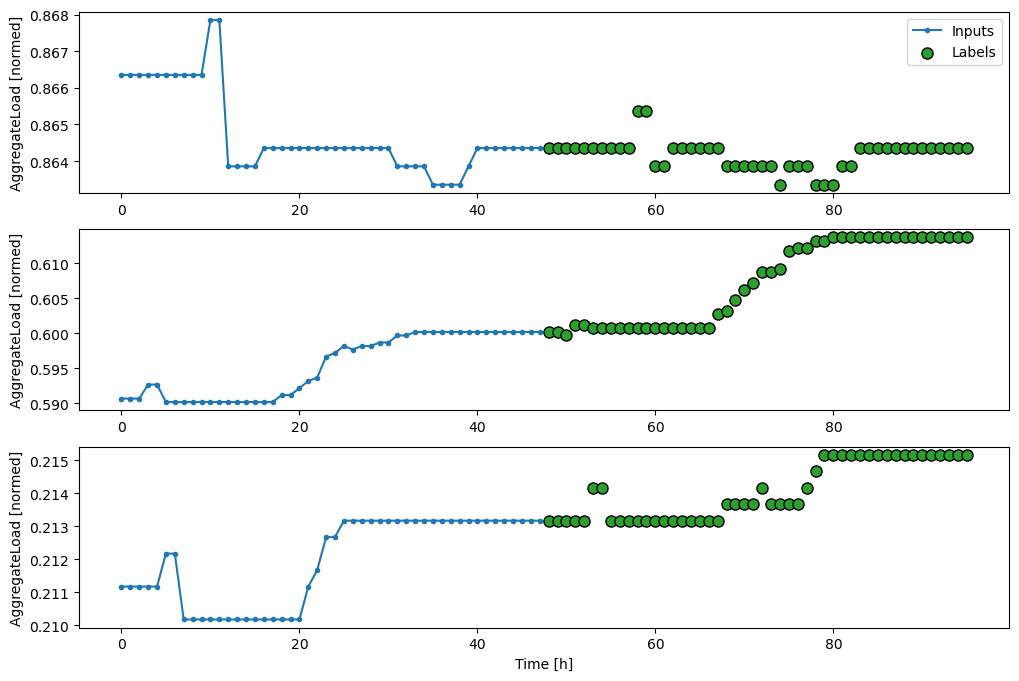

In [78]:
# Yhden jakson ennuste monivaiheiselle ajalle
OUT_STEPS = 48 # 24 tunnin ennuste
# IN_STEPS = 336 # Katsotaan taakse 1 viikko
IN_STEPS = 48 # Katsotaan taakse 1 paiva

multi_window = WindowGenerator(
    input_width=IN_STEPS,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['AggregateLoad'],
    train_df=train_data, 
    val_df=val_data, 
    test_df=test_data,
)

num_out_features = multi_window.num_out_features
# Tulostetaan ennustettavien ominaisuuksien lukumäärä
multi_window.plot() # Piirretään esimerkkidata
multi_window

- **Syöte ja ennustetut arvot**: Syötteet (Input indices) kattavat 1 päivän (48 aikaväliä), ja ennustettavat arvot (Label indices) ovat seuraavat 48 aikaväliä.
- **Graafinen havainto**: Sininen viiva näyttää syötearvot, ja vihreät pisteet edustavat ennustettavia arvoja.  


In [79]:
multi_val_performance = {}
multi_test_performance = {}

- Tässä funktiossa koulutetaan annettu syväoppimismalli käyttäen **train** ja **validation** dataikkunoita:

1. **Varhainen pysäytys**: Koulutus lopetetaan automaattisesti, jos validointihäviö (`val_loss`) ei parane `patience` arvon sisällä.
2. **Mallin tallennus**: Parhaat painot tallennetaan `ModelCheckpoint` callbackin avulla.
3. **Mallin palautus**: Lopuksi painot palautetaan parhaalle epochille, jolloin saadaan paras validointitulos.


In [82]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  # Aikaisen pysäytyksen määrittely: pysäytä harjoitus, jos validointihäviö ei parane tietyn ajan jälkeen
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  # Mallin kääntäminen: määritellään häviöfunktio, optimointimenetelmä ja seurattavat metrit
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  # Parhaan mallin tallennus: tallenna vain paras tarkistuspiste validointihäviön perusteella
  checkpoint_filepath = '/tmp/' + model.name + '/checkpoint'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)
    
  # Mallin harjoitus
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])

  # Palautetaan painot parhaasta validointihäviön ajankohdasta
  model.load_weights(checkpoint_filepath)
    
  return history


- Luomme yksinkertaisen ennusteen ("Naive Forecast") siirtämällä **AggregateLoad** arvoja viikon taaksepäin (336 mittausjaksoa, 30 min välein).

- Tavoitteena on ennustaa nykyinen energiankulutusarvo käyttämällä saman viikonpäivän ja ajan edellistä arvoa.


In [83]:
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39223 entries, 0 to 39222
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
38887 non-null  float64
dtypes: float64(1)
memory usage: 306.6 KB
None
count    38887.000000
mean      4251.170545
std       1763.759452
min         64.000000
25%       4131.000000
50%       5163.000000
75%       5367.000000
max       5532.000000
Name: AggregateLoad, dtype: float64


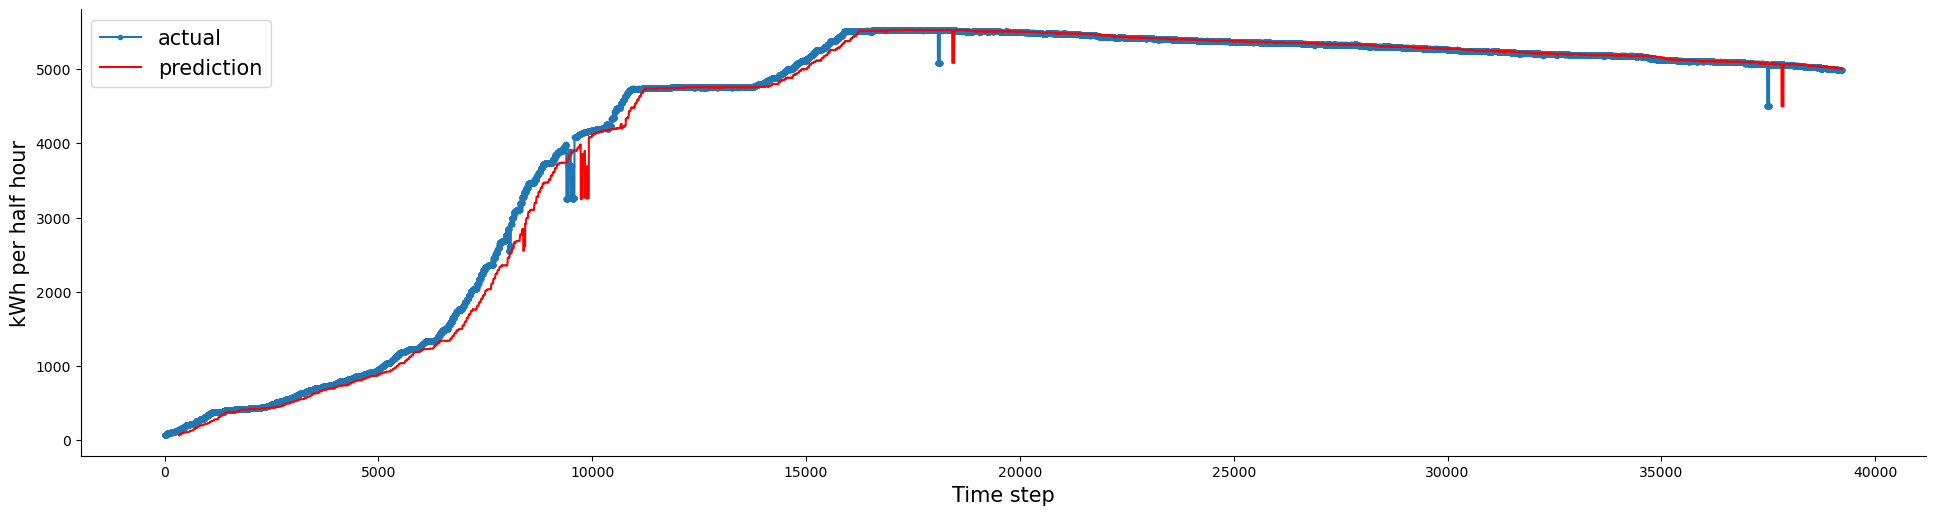

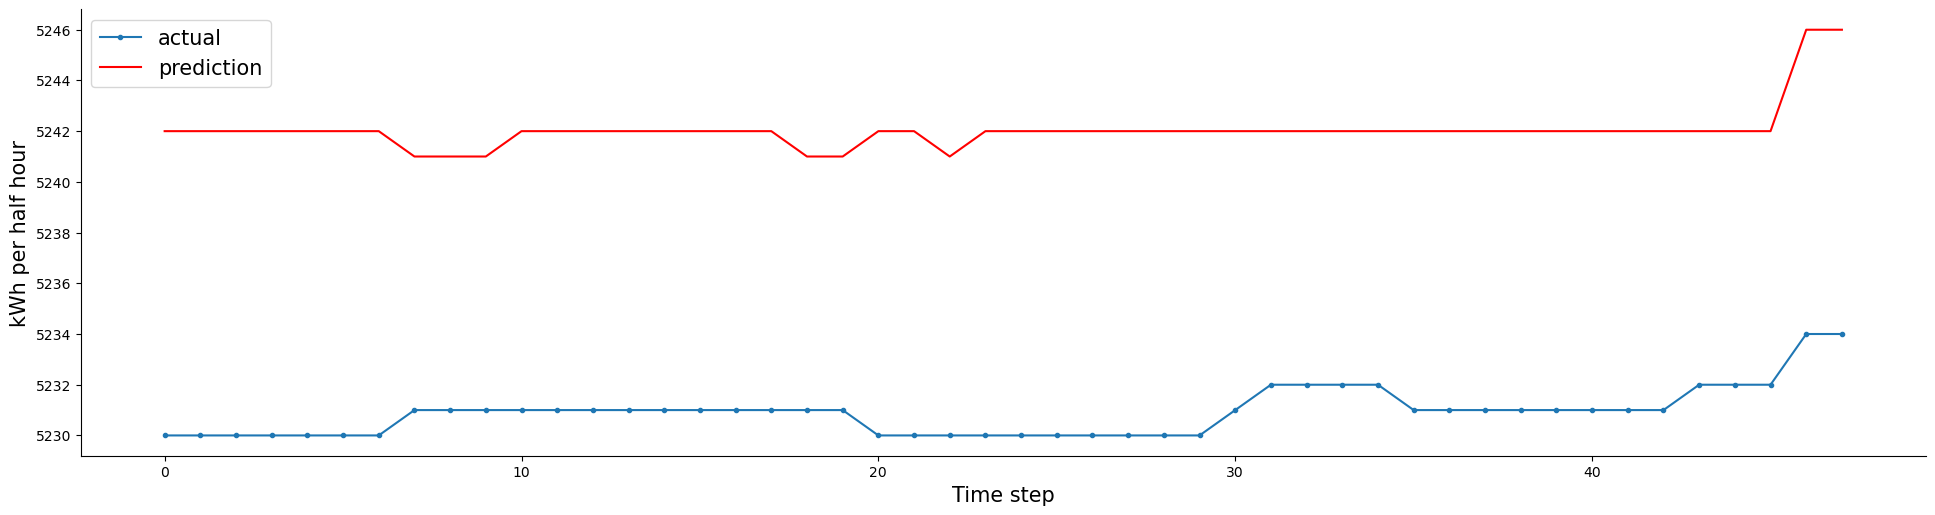

In [85]:
prediction_plot(mergeData.AggregateLoad, NaiveForecast)
prediction_plot(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

Naive Forecast menetelmää käyttäen ennustamme AggregateLoadin yhden viikon viiveellä. Ensimmäisestä kaaviosta nähdään, että kaikkien tietojen ennuste näyttää samanlaista trendiä kuin todelliset tiedot, mutta tekee virheitä suurissa muutoksissa. Toisessa kaaviossa havaitaan merkittävä ero ennustettujen ja todellisten arvojen välillä lyhyen ajan. Tämä osoittaa, että Naive Forecast ei ole herkkä äkillisille muutoksille ja sen suorituskyky on rajallinen.

In [86]:
# Standardointi tehdään koulutusdatan keskiarvon ja keskihajonnan perusteella.
NaiveForecastNormed = NaiveForecast.transform(lambda x: (x - train_mean) / train_std)
NaiveForecastNormed.describe() #

,weekOfYear_sin,weekOfYear_cos,dayOfWeek_sin,dayOfWeek_cos,dailyTrend,dailySeasonal,dailyResid,weeklyTrend,weeklySeasonal,weeklyResid,AggregateLoad_1dayLag,AggregateLoad_1weekLag,AggregateLoad_halfhourdiff,temperature,temp_daymax,AggregateLoad
count,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000,38887.000000
mean,6175.863990,6138.952607,6014.502846,6009.406581,0.250239,2258.148315,215.871073,0.250347,1255.965098,96.983172,0.254547,0.280353,389.865300,737.276736,696.862330,0.250214
std,2562.396774,2547.053918,2495.343947,2493.230152,0.880854,936.878505,89.562356,0.881153,521.085168,40.237574,0.878517,0.865549,161.758335,306.573811,289.977515,0.880772
min,92.725903,92.238507,90.548383,90.470274,-1.840911,33.995765,3.249756,-1.841514,18.907253,1.459043,-1.831057,-1.774462,5.850499,9.469534,8.454788,-1.840740
25%,6001.279742,5965.413716,5844.487120,5839.534875,0.190223,2194.315800,209.768904,0.190311,1220.461907,94.241658,0.194690,0.221381,378.844190,716.388886,677.105239,0.190205
50%,7500.573462,7455.730120,7304.547306,7298.358250,0.705623,2742.496345,262.173075,0.705886,1525.356031,117.785218,0.708723,0.727825,473.491225,895.769455,846.775085,0.705556
75%,7796.945477,7750.327549,7593.163854,7586.730313,0.807505,2850.857615,272.532039,0.807802,1585.625800,122.439178,0.810334,0.827937,492.200522,931.228404,880.314473,0.807428
max,8036.658136,7988.604881,7826.603710,7819.972422,0.889909,2938.502761,280.910613,0.890234,1634.373407,126.203410,0.892520,0.908909,507.333042,959.908437,907.441919,0.889824


In [87]:
# laske virheet normoidulle ennusteelle
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# lasketaan virheet koulutusdatan validointi ja testijaksoille
valNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])

# laske virheet koulutusdatan validointi ja testijaksoille
testNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

valNaiveMAE:  0.003898715176893666
testNaiveMAE:  0.008504211923715805


In [117]:
# laske virheet ei normoidulle ennusteelle
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))

valNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size:train_size+val_size], NaiveForecast[train_size:train_size+val_size])

testNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:], NaiveForecast[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

Naive Root Mean Squared Error(RMSE): 125.00; Naive Mean Absolute Error(MAE) : 58.54; Naive Mean Absolute Percantage Error(MAPE) : 0.03 
valNaiveMAE:  7.807241203467618
testNaiveMAE:  17.029824114198316


- Normoimattomassa datassa virheet (MAE ja RMSE) ovat suuria, mikä kertoo alkuperäisen yksikkömuodon vaikutuksesta. 
- Normoidussa datassa virheet pienenevät huomattavasti, koska arvot skaalataan samaan mittakaavaan. Validaatiossa malli toimii tarkemmin kuin testidatassa, mikä on odotettavaa, sillä testidata on mallille tuntematonta.

In [118]:
# funktio mallin virheiden laskemiseen
def plot_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    return

- RepeatBaseline malli käyttää syötteitä ennusteina muuttamatta niitä. Sitä käytetään vertailukohtana, jotta voidaan arvioida monimutkaisempien mallien tarkkuutta.

In [119]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size], verbose=0)
multi_test_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:], verbose=0)
print(multi_val_performance['Baseline'], multi_test_performance['Baseline'])

[2.376151314820163e-05, 0.003898715367540717] [0.0009877447737380862, 0.008504211902618408]


# MALLINNUS MultiLayerPerceptron Mallilla

Epoch 1/100
781/794 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1399 - mean_absolute_error: 0.1775
Epoch 1: val_loss improved from inf to 0.00054, saving model to /tmp/MLP/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1381 - mean_absolute_error: 0.1754 - val_loss: 5.4331e-04 - val_mean_absolute_error: 0.0184
Epoch 2/100
753/794 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6412e-04 - mean_absolute_error: 0.0145
Epoch 2: val_loss improved from 0.00054 to 0.00022, saving model to /tmp/MLP/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.6126e-04 - mean_absolute_error: 0.0145 - val_loss: 2.2017e-04 - val_mean_absolute_error: 0.0115
Epoch 3/100
763/794 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5285e-04 - mean_absolute_error: 0.0116
Epoch 3: val_loss did not improve from 0.00022
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.5483e-04 - mean_absolute_error: 0.0116 - val_loss: 3.7444e-04 - val_mean_absolute_error: 0.0150
Epoch 4/100
772/794 ━━━━━━━━━━

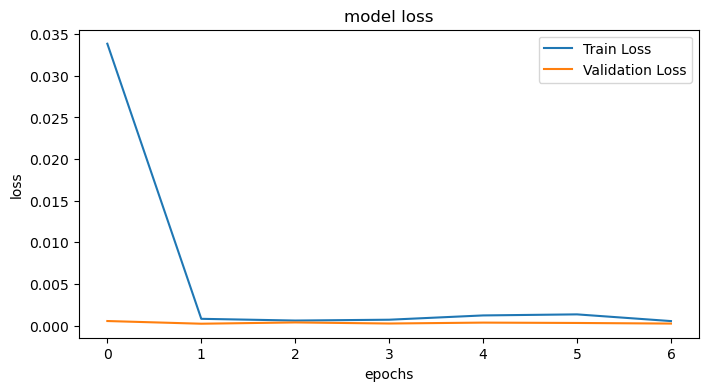

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1833e-04 - mean_absolute_error: 0.0115


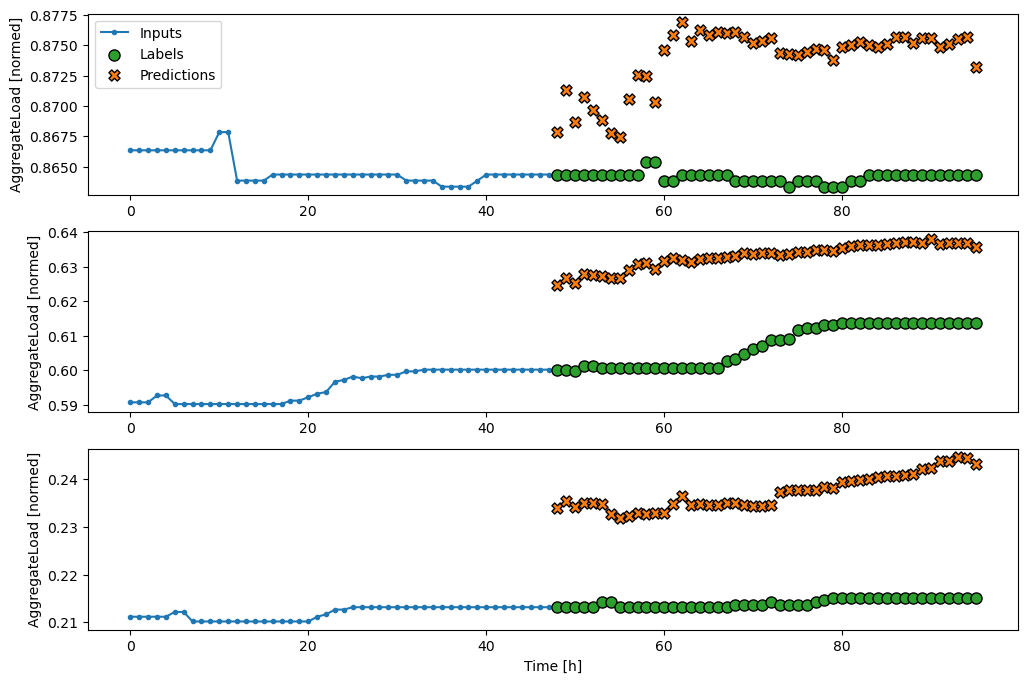

In [139]:
multi_MLP_model = tf.keras.Sequential([
    # Ota viimeinen aikajakso.
    # Muoto [erä, aika, piirteet] => [erä, 1, piirteet]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Muoto => [erä, 1, dense_yksiköt]
    tf.keras.layers.Dense(64, activation='relu'),
    # Muoto => [erä, OUT_STEPS * piirteet]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Muoto => [erä, OUT_STEPS, piirteet]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="MLP")

# Mallin opetus ja tallennus
multi_MLP_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = compile_and_fit(multi_MLP_model, multi_window)
multi_MLP_model.save('multi_MLP_model.keras')
plot_model_loss(history)

# Mallin arviointi validointiaineistolla ja testiaineistolla
multi_val_performance['MLP'] = multi_MLP_model.evaluate(multi_window.val)
multi_test_performance['MLP'] = multi_MLP_model.evaluate(multi_window.test, verbose=0)

# Mallin ennusteiden visualisointi
multi_window.plot(multi_MLP_model)


- Mallin häviö (loss) laskee nopeasti ja vakiintuu, mikä osoittaa nopeaa oppimista. Ennusteet (oranssi) ja todelliset arvot (vihreä) vastaavat osittain, mutta hajonta ja ennustevirheet lisääntyvät myöhemmissä vaiheissa.

# CNN malli

Epoch 1/100
764/794 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0869 - mean_absolute_error: 0.1189
Epoch 1: val_loss improved from inf to 0.00020, saving model to /tmp/CNN/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0842 - mean_absolute_error: 0.1158 - val_loss: 1.9713e-04 - val_mean_absolute_error: 0.0118
Epoch 2/100
757/794 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mean_absolute_error: 0.0143
Epoch 2: val_loss improved from 0.00020 to 0.00016, saving model to /tmp/CNN/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0143 - val_loss: 1.6064e-04 - val_mean_absolute_error: 0.0103
Epoch 3/100
757/794 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5456e-04 - mean_absolute_error: 0.0121
Epoch 3: val_loss improved from 0.00016 to 0.00013, saving model to /tmp/CNN/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.5435e-04 - mean_absolute_error: 0.0121 - val_loss: 1.2987e-04 - val_mean_absolute_error

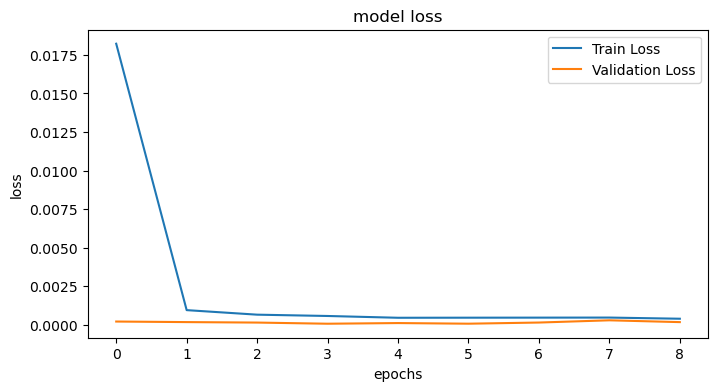

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4791e-05 - mean_absolute_error: 0.0059


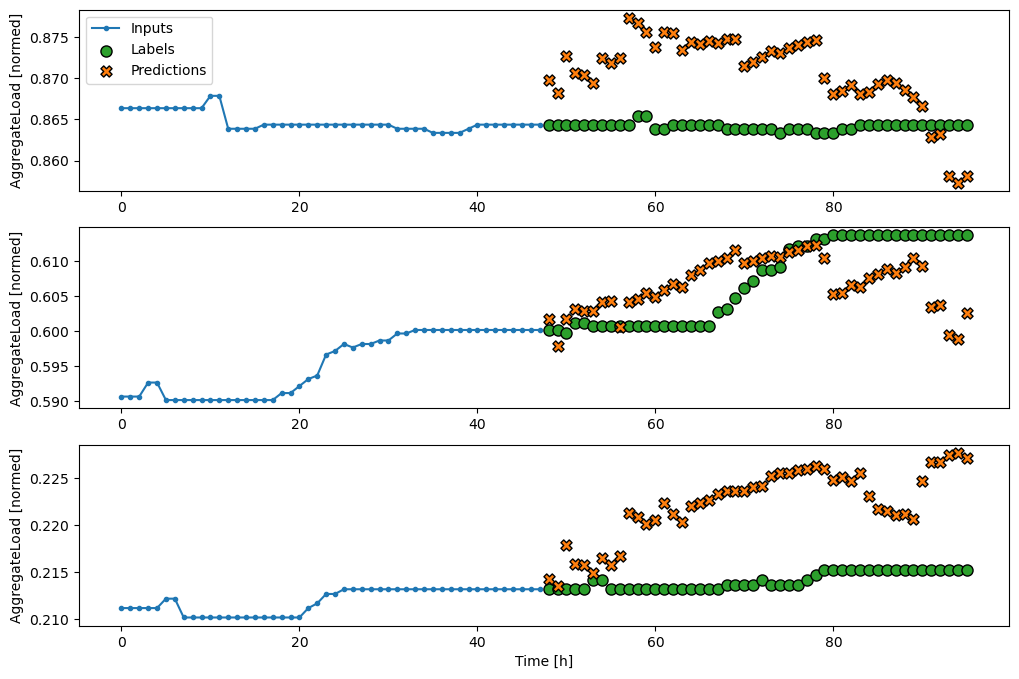

In [140]:
CONV_WIDTH = 10
multi_cnn_model = tf.keras.Sequential([
    # Käytä viimeiset CONV_WIDTH-aikajaksot.
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Konvoluutiokerros
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Muoto => [erä, OUT_STEPS * piirteet]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Muoto => [erä, OUT_STEPS, piirteet]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="CNN")

# Mallin opetus ja tallennus
multi_cnn_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = compile_and_fit(multi_cnn_model, multi_window)
multi_cnn_model.save('multi_cnn_model.keras')
plot_model_loss(history)

# Mallin arviointi validointiaineistolla ja testiaineistolla
multi_val_performance['CNN'] = multi_cnn_model.evaluate(multi_window.val)
multi_test_performance['CNN'] = multi_cnn_model.evaluate(multi_window.test, verbose=0)

# Mallin ennusteiden visualisointi
multi_window.plot(multi_cnn_model)


- Ensimmäisen epochin jälkeen koulutus ja validointihäviöt laskevat nopeasti lähelle nollaa. Tämä viittaa siihen, että malli on oppinut datan nopeasti ja mahdollisesti ylisovittanut, koska validointihäviö ei parane merkittävästi useampien epochien jälkeen.


## RECURRENT NEURAL NETWORK MALLI

Epoch 1/100
790/794 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0847 - mean_absolute_error: 0.1347
Epoch 1: val_loss improved from inf to 0.00043, saving model to /tmp/RNN/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0843 - mean_absolute_error: 0.1341 - val_loss: 4.2748e-04 - val_mean_absolute_error: 0.0165
Epoch 2/100
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1111e-04 - mean_absolute_error: 0.0125
Epoch 2: val_loss improved from 0.00043 to 0.00033, saving model to /tmp/RNN/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.1101e-04 - mean_absolute_error: 0.0125 - val_loss: 3.2982e-04 - val_mean_absolute_error: 0.0142
Epoch 3/100
782/794 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6243e-04 - mean_absolute_error: 0.0097
Epoch 3: val_loss improved from 0.00033 to 0.00017, saving model to /tmp/RNN/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.6211e-04 - mean_absolute_error: 0.0097 - val_loss: 1.6662e-04 - val_mean_absolu

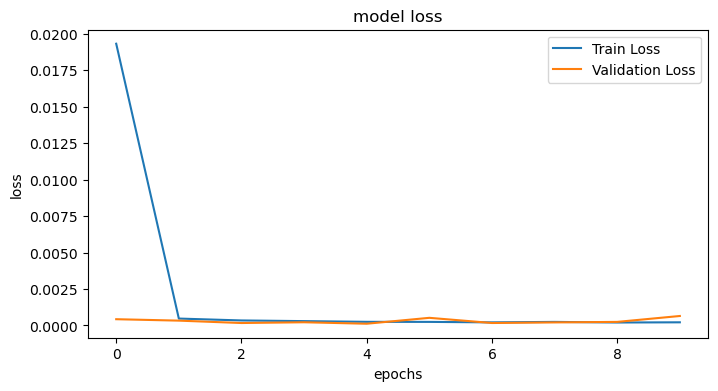

181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1178e-04 - mean_absolute_error: 0.0079


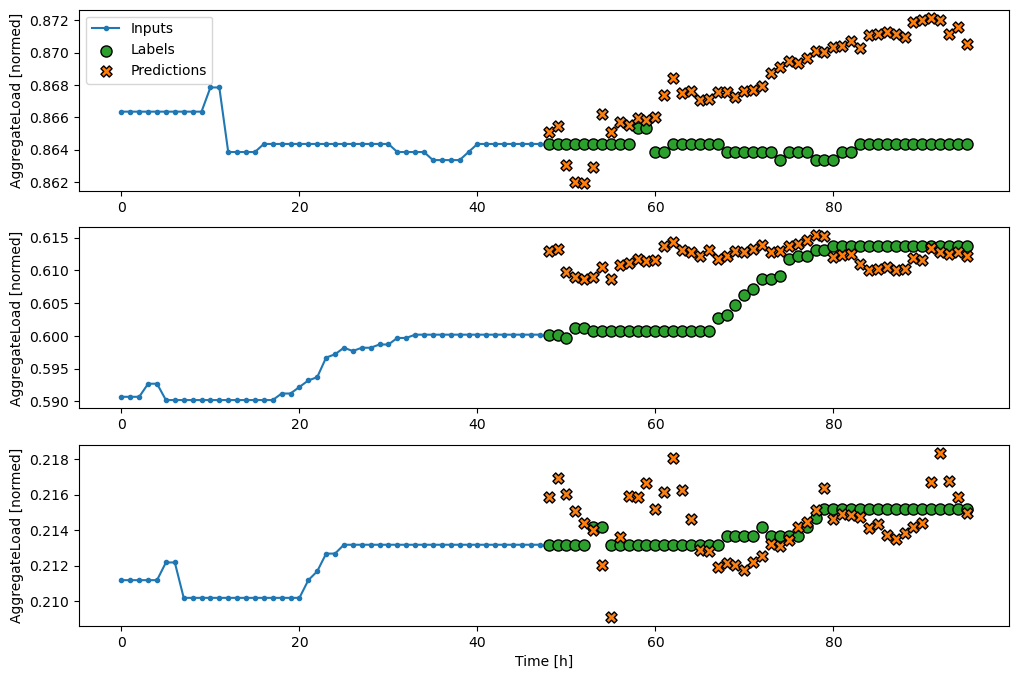

In [141]:
multi_rnn_model = tf.keras.Sequential([
    # Lisää yksinkertainen RNN-kerros.
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    # Muoto => [erä, OUT_STEPS * piirteet]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Muoto => [erä, OUT_STEPS, piirteet]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="RNN")

# Mallin opetus ja tallennus
multi_rnn_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = compile_and_fit(multi_rnn_model, multi_window)
multi_rnn_model.save('multi_rnn_model.keras')
plot_model_loss(history)

# Mallin arviointi validointiaineistolla ja testiaineistolla
multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_test_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)

# Mallin ennusteiden visualisointi
multi_window.plot(multi_rnn_model)


- Mallin treenaus ja validointihäviöt laskevat nopeasti ja vakiintuvat lähes nollaan, mikä osoittaa nopeaa oppimista.  
- Vähäinen ero treenaus ja validointihäviöiden välillä viittaa siihen, että malli ei ylioppi ja toimii hyvin testidatalla.

## Long Short Term Memory (LSTM) Model

Epoch 1/100
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1013 - mean_absolute_error: 0.1445
Epoch 1: val_loss improved from inf to 0.01873, saving model to /tmp/LSTM/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1011 - mean_absolute_error: 0.1443 - val_loss: 0.0187 - val_mean_absolute_error: 0.1161
Epoch 2/100
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.1423e-04 - mean_absolute_error: 0.0098
Epoch 2: val_loss improved from 0.01873 to 0.01465, saving model to /tmp/LSTM/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 3.1415e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0146 - val_mean_absolute_error: 0.1018
Epoch 3/100
793/794 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3198e-04 - mean_absolute_error: 0.0079
Epoch 3: val_loss improved from 0.01465 to 0.01457, saving model to /tmp/LSTM/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 2.3195e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0146 - val_mean_absolute_erro

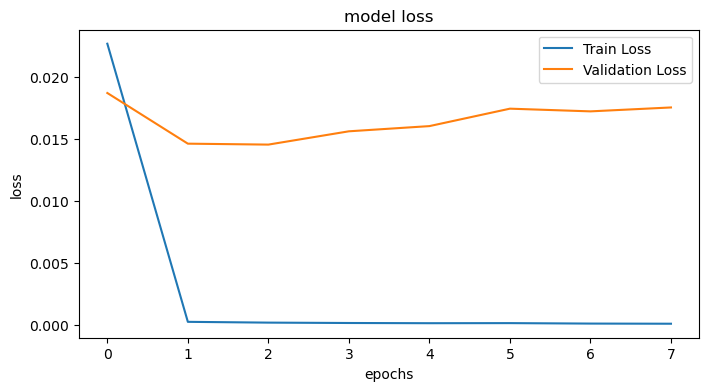

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - mean_absolute_error: 0.1016


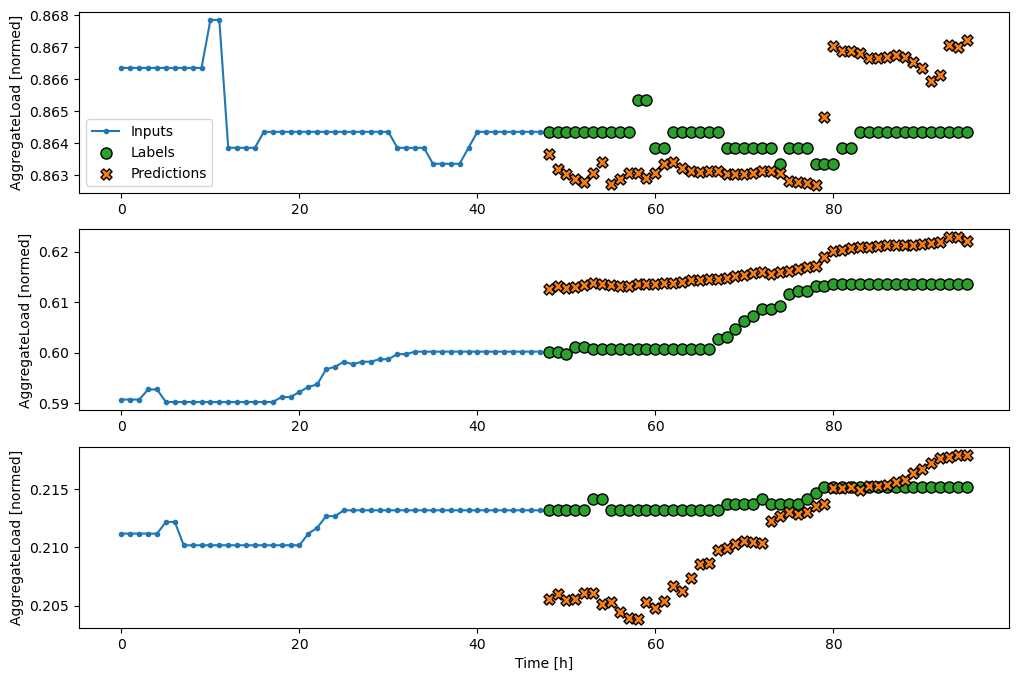

In [142]:
multi_lstm_model = tf.keras.Sequential([
    # LSTM-kerros
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Muoto => [erä, OUT_STEPS * piirteet]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Muoto => [erä, OUT_STEPS, piirteet]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="LSTM")

# Mallin opetus ja tallennus
multi_lstm_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = compile_and_fit(multi_lstm_model, multi_window)
multi_lstm_model.save('multi_lstm_model.keras')
plot_model_loss(history)

# Mallin arviointi validointiaineistolla ja testiaineistolla
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

# Mallin ennusteiden visualisointi
multi_window.plot(multi_lstm_model)


- Mallin menetys laskee jyrkästi ensimmäisten epochien aikana, minkä jälkeen se tasaantuu sekä koulutus että validointidatassa. 
- Tämä viittaa siihen, että malli oppii nopeasti, eikä ylitreenausta tapahdu, koska validointihäviö pysyy lähellä harjoitushäviötä.

## Gated Recurrent unit (GRU) Malli
- Kuten LSTM, GRU on suunniteltu mallintamaan peräkkäistä dataa mahdollistamalla tietojen valikoiva muistaminen tai unohtaminen ajan mittaan. GRU:lla on kuitenkin yksinkertaisempi arkkitehtuuri kuin LSTM:llä, ja siinä on vähemmän parametreja, mikä voi helpottaa harjoittelua ja tehdä laskennallisesti tehokkaammaksi.
- https://medium.com/@anishnama20/understanding-gated-recurrent-unit-gru-in-deep-learning-2e54923f3e2

Epoch 1/100
790/794 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0908 - mean_absolute_error: 0.1302
Epoch 1: val_loss improved from inf to 0.00077, saving model to /tmp/GRU/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0903 - mean_absolute_error: 0.1297 - val_loss: 7.7409e-04 - val_mean_absolute_error: 0.0241
Epoch 2/100
789/794 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8603e-04 - mean_absolute_error: 0.0116
Epoch 2: val_loss improved from 0.00077 to 0.00024, saving model to /tmp/GRU/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 3.8583e-04 - mean_absolute_error: 0.0116 - val_loss: 2.3765e-04 - val_mean_absolute_error: 0.0129
Epoch 3/100
789/794 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9704e-04 - mean_absolute_error: 0.0088
Epoch 3: val_loss improved from 0.00024 to 0.00007, saving model to /tmp/GRU/checkpoint.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.9683e-04 - mean_absolute_error: 0.0088 - val_loss: 6.6879e-05 - val_mean_

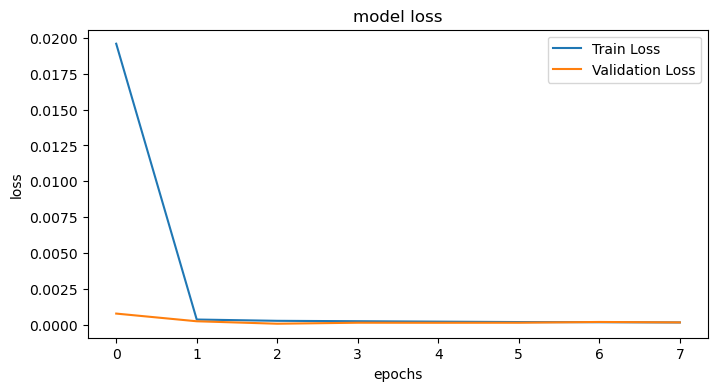

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.7339e-05 - mean_absolute_error: 0.0065


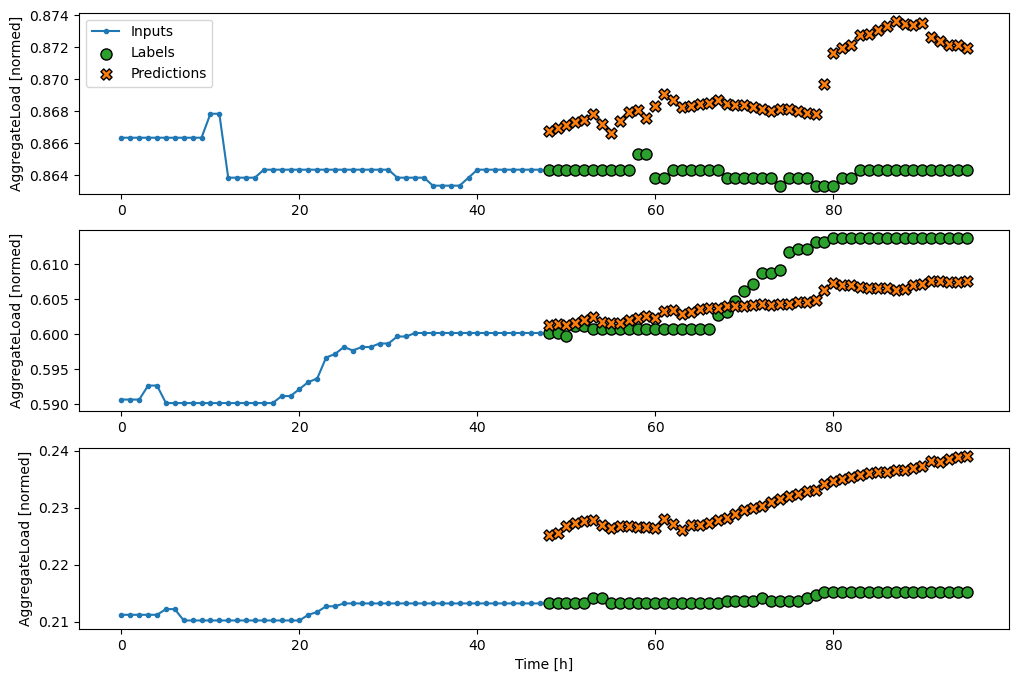

In [143]:
multi_gru_model = tf.keras.Sequential([
    # GRU-kerros
    tf.keras.layers.GRU(64, return_sequences=False),
    # Muoto => [erä, OUT_STEPS * piirteet]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Muoto => [erä, OUT_STEPS, piirteet]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="GRU")

# Mallin opetus ja tallennus
multi_gru_model.compile(loss='mse', optimizer='adam', metrics=['mae'])
history = compile_and_fit(multi_gru_model, multi_window)
multi_gru_model.save('multi_gru_model.keras')
plot_model_loss(history)

# Mallin arviointi validointiaineistolla ja testiaineistolla
multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_test_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)

# Mallin ennusteiden visualisointi
multi_window.plot(multi_gru_model)


- **Ensimmäinen kuva**: Mallin häviö (loss) laskee nopeasti ensimmäisillä epoch kierroksilla ja vakautuu lähes nollaan, mikä viittaa hyvään oppimiseen ja pieneen virheeseen.  
- **Toinen kuva**: Ennustukset (oranssi) ja todelliset arvot (vihreä) ovat hyvin lähellä toisiaan, mutta joitain poikkeamia näkyy varsinkin ajoittain suurilla arvoilla.

## Mallin arviointi ja valinta

In [144]:
print(multi_val_performance)
print(multi_test_performance)



{'Baseline': [2.376151314820163e-05, 0.003898715367540717], 'MLP': [0.00022016512230038643, 0.011525403708219528], 'CNN': [5.521625280380249e-05, 0.005894232541322708], 'RNN': [0.0001181907209684141, 0.008088224567472935], 'GRU': [6.687896529911086e-05, 0.006497149355709553], 'LSTM': [0.014572981745004654, 0.10378718376159668]}
{'Baseline': [0.0009877447737380862, 0.008504211902618408], 'MLP': [0.000757915317080915, 0.020223762840032578], 'CNN': [0.0004801370669156313, 0.013167005032300949], 'RNN': [0.0005386645207181573, 0.013364608399569988], 'GRU': [0.0012186439707875252, 0.030050277709960938], 'LSTM': [0.02645772136747837, 0.1488185077905655]}


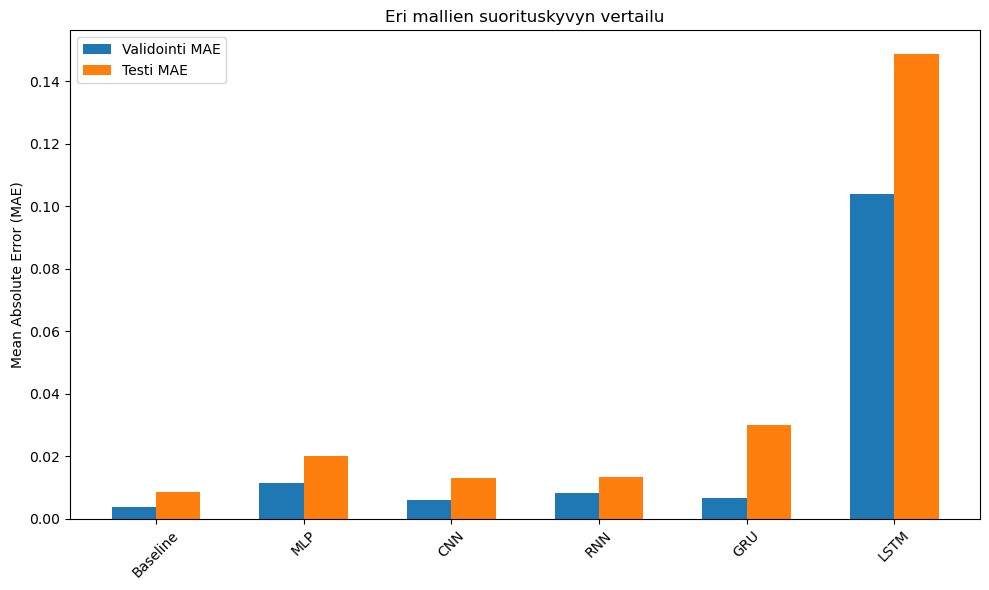

In [145]:
# Mallien nimet ja MAE-arvot validointi- ja testiaineistoilla
x = np.arange(len(multi_test_performance))  # Mallien määrä
width = 0.3  # Pylväiden leveys

# Haetaan MAE-arvot
metric_name = 'mae'
val_mae = [v[1] for v in multi_val_performance.values()]  # Validointi MAE
test_mae = [v[1] for v in multi_test_performance.values()]  # Testi MAE

# Piirretään vertailukaavio
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, val_mae, width, label='Validointi MAE')
plt.bar(x + width/2, test_mae, width, label='Testi MAE')

# Asetetaan x-tikulle mallien nimet
plt.xticks(ticks=x, labels=multi_test_performance.keys(), rotation=45)

# Asetetaan akselit ja otsikko
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Eri mallien suorituskyvyn vertailu')
plt.legend()
plt.tight_layout()
plt.show()


- Baseline-malli on yksinkertainen ja tuottaa odotetusti korkeamman virheen kuin useimmat muut mallit.
- MLP ja CNN suoriutuvat hyvin pienellä MAE-arvolla, mikä osoittaa niiden tarkkuuden olevan riittävän hyvä.
- GRU ja RNN parantavat hieman tuloksia, mutta GRU-mallin testisuorituskyvyssä näkyy nousua verrattuna validointiin.
- LSTM-mallilla on huomattavasti suurempi virhe, mikä viittaa siihen, että malli ylisovittuu tai ei opi datasta tehokkaasti.

In [ ]:
# Ladataan mallit
multi_MLP_model = tf.keras.models.load_model('multi_MLP_model.keras', safe_mode=False)
# Mallien nimet ja MAE-arvot validointi- ja testiaineistoilla
model_list = [multi_MLP_model, multi_cnn_model, multi_rnn_model, multi_lstm_model, multi_gru_model]
for model in model_list:
    print(model.name)


MLP
CNN
RNN
LSTM
GRU


In [148]:
import pickle # pickle kirjasto mallien tallentamiseen ja lataamiseen
with open('model eval results.pkl', 'wb') as f:
    pickle.dump(multi_val_performance, f) # tallennetaan validointiaineiston suorituskyky

with open('model test results.pkl', 'wb') as f:
    pickle.dump(multi_test_performance, f) # tallennetaan testiaineiston suorituskyky

In [149]:
with open('model eval results.pkl', 'rb') as f:
    multi_val_performance = pickle.load(f)

with open('model test results.pkl', 'rb') as f:
    multi_test_performance = pickle.load(f)

print(multi_val_performance)
print(multi_test_performance)

{'Baseline': [2.376151314820163e-05, 0.003898715367540717], 'MLP': [0.00022016512230038643, 0.011525403708219528], 'CNN': [5.521625280380249e-05, 0.005894232541322708], 'RNN': [0.0001181907209684141, 0.008088224567472935], 'GRU': [6.687896529911086e-05, 0.006497149355709553], 'LSTM': [0.014572981745004654, 0.10378718376159668]}
{'Baseline': [0.0009877447737380862, 0.008504211902618408], 'MLP': [0.000757915317080915, 0.020223762840032578], 'CNN': [0.0004801370669156313, 0.013167005032300949], 'RNN': [0.0005386645207181573, 0.013364608399569988], 'GRU': [0.0012186439707875252, 0.030050277709960938], 'LSTM': [0.02645772136747837, 0.1488185077905655]}


- Tämä funktio sekoittaa (permutoidut) tietyt sarakkeet (piirteet) aikasarjadatassa ja palauttaa uuden WindowGenerator objektin.
- Tarkoituksena on mitata piirteiden tärkeys aikasarjamallille permutaation avulla. Sekoittamalla yksittäinen sarake ja arvioimalla sen vaikutus mallin suoritukseen, voidaan päätellä, kuinka tärkeä kyseinen piirre on mallin ennustetarkkuudelle.

In [150]:
# funktio aikasarjadatan luomiseen piirteiden permutaatiota varten
def generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=None,
                               cols_to_shuffle=None,
                               train_df=train_data, val_df=val_data, test_df=test_data):
    
    train = train_df.copy()
    val = val_df.copy()
    test = test_df.copy()
    
    # sekoitetaan satunnaisesti tietyt sarakkeet
    for col in cols_to_shuffle:
        train[col] = train[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        val[col] = val[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        test[col] = test[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)

    # Luo uusi aikasarjaikkuna permutoiduilla piirteillä
    feat_perm_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                               train_df=train, val_df=val, test_df=test,)
    
    return feat_perm_window


- **Permutaatiotärkeys** mittaa, kuinka tärkeä tietty piirre tai piirrejoukko on mallin suorituskyvylle.
- Piirteiden arvot sekoitetaan satunnaisesti ja malli arvioidaan uudelleen. Tärkeys lasketaan vertaamalla validointitarkkuuden huononemista alkuperäiseen (perustaso) tarkkuuteen.
- Tämä auttaa tunnistamaan, mitkä piirteet vaikuttavat eniten mallin tarkkuuteen ja mitkä piirteet voidaan mahdollisesti poistaa.

In [151]:
# Määritä funktio piirreryhmän permutaatiotärkeyden laskemiseksi annetulle mallille
def calculate_permutation_importance_group(model, feature_group, baseline_val_perf, baseline_test_perf):

    # Sekoita piirrejoukon arvoja satunnaisesti
    feat_perm_window = generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                               cols_to_shuffle=feature_group,
                               train_df=train_data, val_df=val_data, test_df=test_data)
    
    # Arvioi malli sekoitetuilla piirteillä validointiaineistolla
    val_perf_shuffle = model.evaluate(feat_perm_window.val, verbose=1)[1] # MAE (Mean Absolute Error)

    # Laske permutaatiotärkeys
    importance = val_perf_shuffle - baseline_val_perf
    
    print('\nMalli: ', model.name, feature_group, 'tärkeys: ', importance)

    return importance


- Väärä importances.values()-käyttö: items() palauttaa tuple-arvoja, joten oikea tapa on purkaa avaimet ja arvot erikseen.
- Sanakirjan järjestäminen: sorted()-funktiota käytettiin itemgetter-avulla piirteiden permutaatiotärkeyden järjestämiseen.
- Korjattu plt.legend: Poistettu plt.legend-kutsu, koska yksittäinen pylväskaavio ei tarvitse legendaa.


In [152]:
from operator import itemgetter # itemgetter-funktio järjestämistä varten 
# käytettävien arvojen hakemiseen

# Määritä funktio visualisoimaan piirteiden permutaatiotärkeys käyttäen pinottua pylväskaaviota
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):

    # Järjestä permutaatiotärkeydet suuruusjärjestykseen
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    features = [item[0] for item in importances]
    importance_values = [item[1] for item in importances]

    # Luo pylväskaavio permutaatiotärkeyksistä
    plt.bar(features, importance_values)
    plt.xlabel('Piirre')
    plt.ylabel('Permutaatiotärkeys')
    plt.title('Piirteiden permutaatiotärkeys mallille: {}'.format(model.name))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


- Tämä prosessi auttaa tunnistamaan, mitkä piirteet tai piirrejoukot vaikuttavat eniten mallin suoritukseen.
- Heikot tai turhat piirteet voidaan tunnistaa ja mahdollisesti poistaa parantaen mallin yksinkertaisuutta ja yleistä suorituskykyä.

In [154]:
# Määritellään syklistä koodatut piirre-ryhmät
feature_groups = {
    'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'],
    'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos']
}

# Luo lista kaikista jo ryhmitellyistä piirteistä
grouped_features = [feature for group in feature_groups.values() for feature in group]

# Lisää yksittäiset piirteet, jotka eivät ole vielä ryhmissä
for feature in val_data.columns:
    if feature not in grouped_features:
        feature_groups[feature] = [feature]

print('feature_groups: ', feature_groups)

# Laske permutaatiotärkeys
permutation_importances_groups = {}
for model in model_list:
    print('\ncalculate baseline model performance with all features.\n', model.name)
    val_perf = model.evaluate(multi_window.val, verbose=1)[1]  # MAE
    test_perf = model.evaluate(multi_window.test, verbose=1)[1]  # MAE

    for group_name, group_features in feature_groups.items():
        importance = calculate_permutation_importance_group(model, group_features, val_perf, test_perf)
        permutation_importances_groups.setdefault(model.name, {})[group_name] = importance


feature_groups:  {'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'], 'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'], 'dailyTrend': ['dailyTrend'], 'dailySeasonal': ['dailySeasonal'], 'dailyResid': ['dailyResid'], 'weeklyTrend': ['weeklyTrend'], 'weeklySeasonal': ['weeklySeasonal'], 'weeklyResid': ['weeklyResid'], 'AggregateLoad_1dayLag': ['AggregateLoad_1dayLag'], 'AggregateLoad_1weekLag': ['AggregateLoad_1weekLag'], 'AggregateLoad_halfhourdiff': ['AggregateLoad_halfhourdiff'], 'temperature': ['temperature'], 'temp_daymax': ['temp_daymax'], 'AggregateLoad': ['AggregateLoad']}

calculate baseline model performance with all features.
 MLP
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 2.1833e-04 - mean_absolute_error: 0.0115
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 7.7892e-04 - mean_absolute_error: 0.0204
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 2.5191e-04 - mean_absolute_error: 0.0126

Malli:  MLP ['weekOfYear_sin', 'weekOfYear_cos'] tärkeys:  0.000980196520686

### Tulosten tulkinta lyhyesti  

- **MLP**-, **CNN**-, **RNN**-, **LSTM**- ja **GRU**-mallien piirteiden tärkeys (permutation importance) laskettiin validointiaineistolla.  
- **`AggregateLoad`**-piirre oli selkeästi tärkein kaikille malleille, mikä osoittaa, että aikaisempi kuormitus vaikuttaa merkittävästi ennusteeseen.  
- **LSTM**-mallissa joillakin piirteillä, kuten **`weekOfYear`** ja **`dayOfWeek`**, oli jopa negatiivista tärkeyttä, mikä voi viitata siihen, että niiden poistaminen parantaisi mallin suorituskykyä.  
- **CNN**- ja **GRU**-mallit osoittivat suurinta riippuvuutta lämpötilaominaisuuksista (**`temperature`** ja **`temp_daymax`**) ja kausivaihteluista (**`dailySeasonal`** ja **`weeklySeasonal`**).  
- **RNN**-malli nosti esiin **`temperature`**-piirteen sekä viikkotrendin (**`weeklyTrend`**) tärkeyden.  

Näiden tulosten perusteella voimme harkita vähemmän merkityksellisten piirteiden poistamista ja keskittyä tärkeimpiin piirteisiin mallien optimoinnissa.

- Alla oleva koodi visualisoi piirteiden permutaatiotärkeyksiä pylväskaaviona, jossa piirteet lajitellaan niiden vaikutuksen mukaan ennustemallin suoritukseen. Tarkoitus on nähdä, mitkä piirteet vaikuttavat eniten mallin ennusteisiin, jotta voimme tunnistaa tärkeimmät piirteet ja mahdollisesti yksinkertaistaa mallia.

In [155]:
from operator import itemgetter, attrgetter
# Määrittele funktio, joka visualisoi permutaatiotärkeydet annetulle piirteelle
# käyttäen pinottua pylväskaaviota plt.stackplot()-funktion avulla
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualisoi permutaatiotärkeydet annetulle piirteelle käyttämällä pinottua pylväskaaviota plt.stackplot()-funktion avulla.

    Args:
        feature: Piirre, jonka permutaatiotärkeys halutaan visualisoida.
        permutation_importances: Sanakirja, joka liittää mallien nimet niiden permutaatiotärkeyksiin.
    """

    # Lajittele permutaatiotärkeydet laskevaan järjestykseen
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    print(importances)
    df = pd.DataFrame(importances, columns=['label', 'value']) # Luo DataFrame lajitteluista
    labels = df['label'].tolist()  # Muunna piirteet listaksi
    values = df['value'].tolist()  # Muunna arvot listaksi

    # Luo pinottu pylväskaavio permutaatiotärkeyksistä
    plt.bar(labels, values)
    plt.xlabel('Piirre')
    plt.ylabel('Permutaatiotärkeys')
    plt.title('Permutaatiotärkeydet mallille: {}'.format(model))
    plt.legend(labels)
    plt.tick_params(rotation=90)
    plt.show()


[('AggregateLoad', 0.014054834842681885), ('dailySeasonal', 0.0030751191079616547), ('temperature', 0.003031565807759762), ('temp_daymax', 0.001603766344487667), ('weeklySeasonal', 0.001350979320704937), ('weekOfYear', 0.0009801965206861496), ('dailyTrend', 0.0005881832912564278), ('dailyResid', 0.0005006454885005951), ('dayOfWeek', 0.00047293584793806076), ('AggregateLoad_1dayLag', 0.0003419704735279083), ('AggregateLoad_1weekLag', 0.00018676836043596268), ('AggregateLoad_halfhourdiff', 0.00012079812586307526), ('weeklyResid', 6.695371121168137e-05), ('weeklyTrend', -1.9455328583717346e-06)]


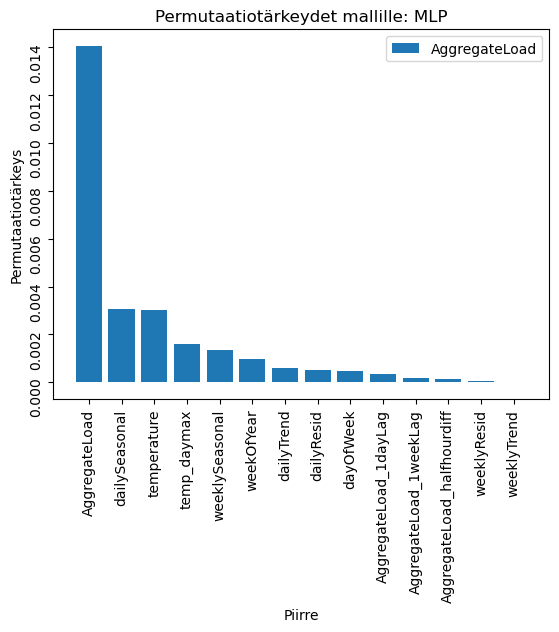

[('AggregateLoad', 0.016510596498847008), ('dayOfWeek', 0.0037122946232557297), ('weekOfYear', 0.0024717962369322777), ('temperature', 0.0019418895244598389), ('dailySeasonal', 0.0015167645178735256), ('weeklySeasonal', 0.0013780486769974232), ('temp_daymax', 0.0012487848289310932), ('weeklyResid', 0.00029703276231884956), ('dailyTrend', 0.0002711513079702854), ('dailyResid', 0.0001849224790930748), ('weeklyTrend', 0.00018418952822685242), ('AggregateLoad_halfhourdiff', 0.00017707888036966324), ('AggregateLoad_1dayLag', -9.959936141967773e-05), ('AggregateLoad_1weekLag', -0.00021505774930119514)]


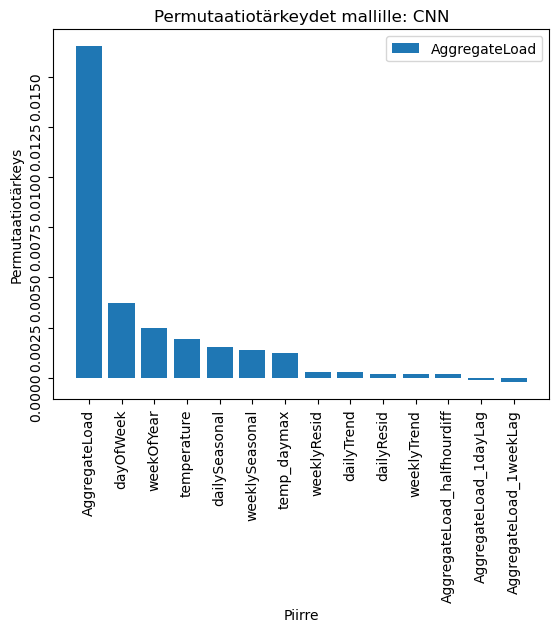

[('AggregateLoad', 0.015288322232663631), ('weekOfYear', 0.005829717963933945), ('temp_daymax', 0.005710724741220474), ('weeklySeasonal', 0.004115930758416653), ('temperature', 0.004041226580739021), ('dayOfWeek', 0.0034376932308077812), ('dailySeasonal', 0.0023137452080845833), ('weeklyTrend', 0.001972251571714878), ('dailyTrend', 0.001060018315911293), ('AggregateLoad_1dayLag', 0.0009327903389930725), ('weeklyResid', 0.0004536416381597519), ('dailyResid', 0.00026137102395296097), ('AggregateLoad_halfhourdiff', 8.436664938926697e-05), ('AggregateLoad_1weekLag', 7.318239659070969e-05)]


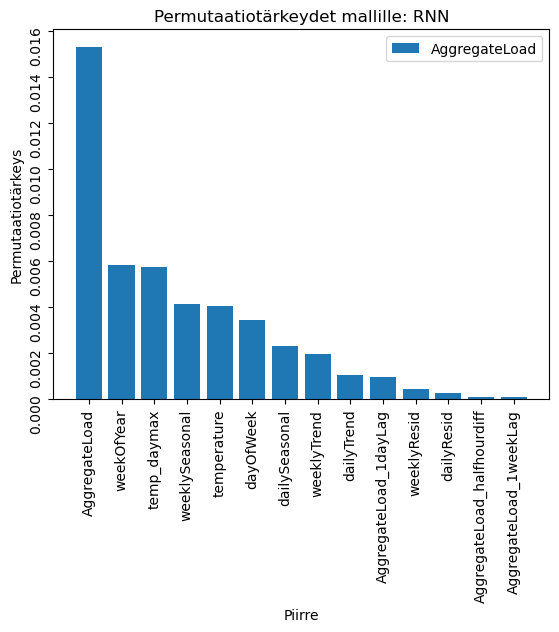

[('AggregateLoad', 0.00945938378572464), ('weeklySeasonal', 0.001115158200263977), ('dailySeasonal', 0.0010852739214897156), ('temp_daymax', 0.0008194148540496826), ('weeklyResid', 0.00026629865169525146), ('AggregateLoad_1weekLag', -1.0415911674499512e-05), ('AggregateLoad_halfhourdiff', -1.8537044525146484e-05), ('dailyResid', -3.454834222793579e-05), ('temperature', -5.910545587539673e-05), ('dailyTrend', -0.00018548965454101562), ('weeklyTrend', -0.00036440789699554443), ('AggregateLoad_1dayLag', -0.000449351966381073), ('weekOfYear', -0.000508330762386322), ('dayOfWeek', -0.0021598637104034424)]


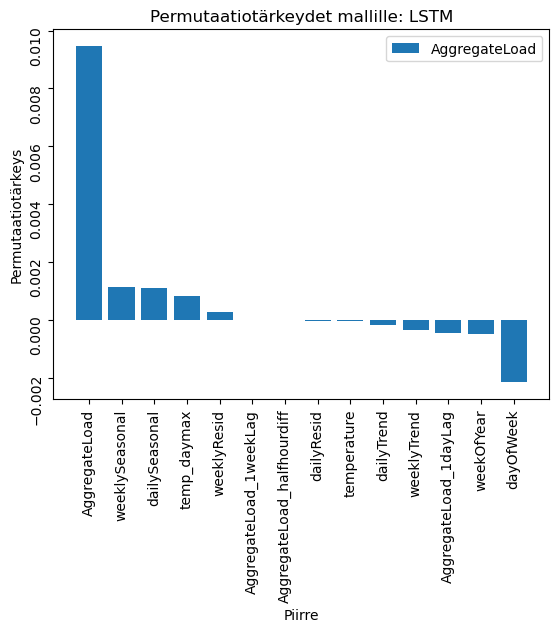

[('AggregateLoad', 0.015126955695450306), ('dailyTrend', 0.002721293829381466), ('temperature', 0.0023840386420488358), ('weeklyTrend', 0.0019128406420350075), ('temp_daymax', 0.001705128699541092), ('weeklySeasonal', 0.0015821168199181557), ('AggregateLoad_1dayLag', 0.0014759190380573273), ('dayOfWeek', 0.0008968720212578773), ('AggregateLoad_1weekLag', 0.0007344372570514679), ('dailySeasonal', 0.0006506708450615406), ('AggregateLoad_halfhourdiff', 0.0004112245514988899), ('weekOfYear', 0.0003875941038131714), ('weeklyResid', 0.0002773529849946499), ('dailyResid', 0.0001283572055399418)]


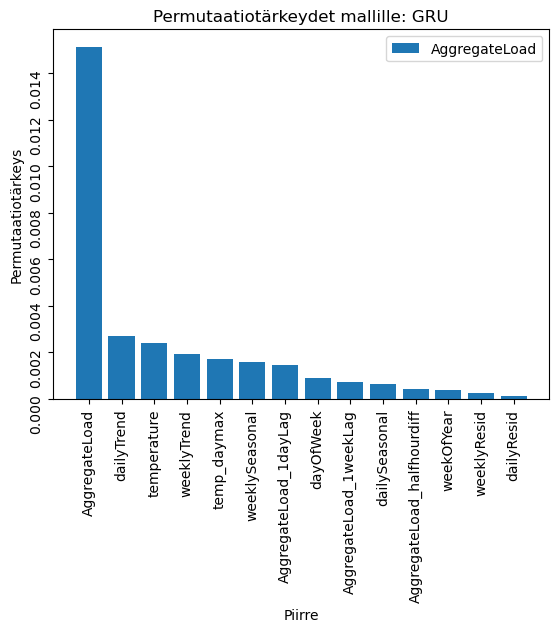

In [156]:
# Visuolisoi permutaatiotärkeydet kaikille malleille ja ryhmille käyttäen pinottua pylväskaaviota 
for model, permutation_importances in permutation_importances_groups.items():
    visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances)

## **Parhaat mallitulokset** (Yhden päivän tulokset: Vertailuarvo, GRU malli)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
[0.7559343  0.75543267 0.754306   0.7531394  0.7530465  0.75310534
 0.75189734 0.7508501  0.7496084  0.74859357 0.7478943  0.7473318
 0.7462657  0.7467936  0.74614596 0.7457816  0.7453423  0.7454282
 0.7457025  0.74628586 0.74676406 0.74749506 0.74779195 0.74816483
 0.7484773  0.74858224 0.7489205  0.749205   0.74968964 0.7502432
 0.7499567  0.7517645  0.7530468  0.75352037 0.754065   0.75465345
 0.7547036  0.7547014  0.7546953  0.75479156 0.754128   0.75339556
 0.7530177  0.7529557  0.7526135  0.75385946 0.75402755 0.7535083 ]
[5263.88315389 5262.87862618 5260.62249706 5258.28627787 5258.10031611
 5258.21812372 5255.79906918 5253.70192662 5251.21543409 5249.18322297
 5247.78289989 5246.65650636 5244.52164627 5245.57881142 5244.28185348
 5243.5522102  5242.6725323  5242.84452902 5243.39382043 5244.56198971
 5245.51960922 5246.98343143 5247.57796001 5248.32467167 5248.95035302
 5249.16054471 5249.83790863 5250.40761047 5251.37812078 5252.48661042
 

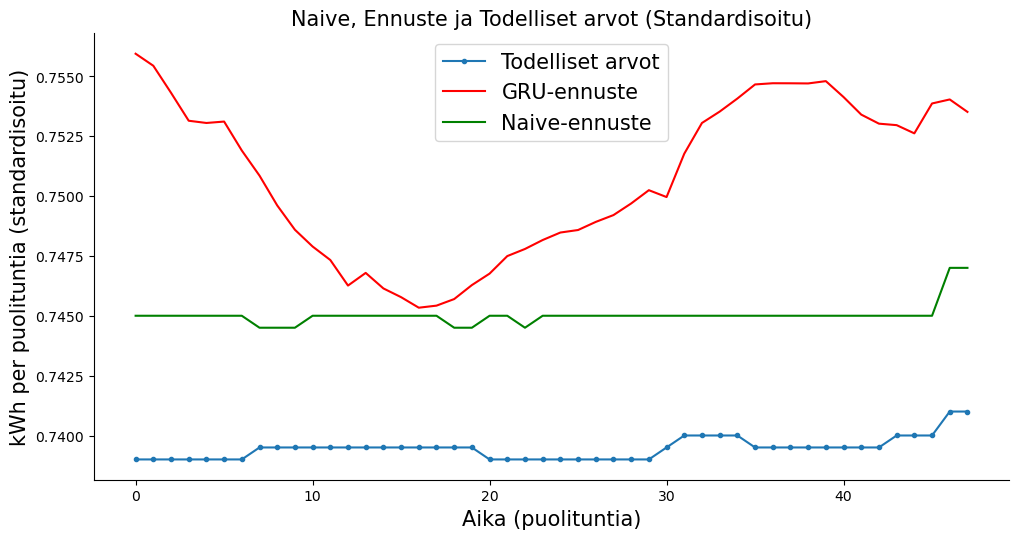

<Figure size 640x480 with 0 Axes>

In [157]:
# Rakenna yhden tietueen datasetti testiaineiston alusta
# print(mergeDataNormed)
# print(train_size+test_size-IN_STEPS)
# print(mergeDataNormed.iloc[train_size+test_size-IN_STEPS:train_size+test_size])

oneDay_ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data[:IN_STEPS],
      targets=None,
      sequence_length=IN_STEPS, # Aikajakson pituus
      sequence_stride=1,        # Siirtymän pituus
      shuffle=False,            # Älä sekoita tietoja
      batch_size=32,)

# Hae ennuste
testYhatNormed = multi_gru_model.predict(oneDay_ds)

# Tulosta ennuste vain kohdemuuttujalle, aggregoitu kuorma
print(testYhatNormed[0,:,-1]) 

# Palauta standardoinnin arvot alkuperäiseen mittakaavaan
testYhat = (np.array(testYhatNormed) * np.array(train_std)) + np.array(train_mean)

# Tulosta tulos alkuperäisessä muodossa
print(testYhat[0,:,-1])

# Piirrä Naive-mallin ennuste, GRU-mallin ennuste ja todelliset arvot ensimmäiselle 24 tunnille testiaineistosta (standardoidut arvot)
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="todelliset arvot")
plt.plot(len_prediction, mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="Todelliset arvot")
plt.plot(len_prediction, testYhatNormed[0,:,-1], 'r', label="GRU-ennuste")
plt.plot(len_prediction, NaiveForecastNormed[train_size+val_size:train_size+val_size+OUT_STEPS].AggregateLoad, 'g', label="Naive-ennuste")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('kWh per puolituntia (standardisoitu)', size=15)
plt.xlabel('Aika (puolituntia)', size=15)
plt.legend(fontsize=15)
plt.title('Naive, Ennuste ja Todelliset arvot (Standardisoitu)', size=15)
plt.show();
plt.savefig('Baseline, Prediction and Actuals (Standardized).png', format='png')


**Tulosten tulkinta**
- Todelliset arvot vaihtelevat vain vähän.
- GRU-malli yrittää oppia kaavoja, mutta poikkeaa todellisista arvoista.
- Naive-malli ei tunnista kaavoja lainkaan ja ennustaa tasaisen arvon.


- Alla lasketaan ennustetarkkuus baseline-naiville mallille sekä validointi- että testisarjoilla vertaamalla ennusteita todellisiin arvoihin. Virhe (MAE) laskee kuinka paljon ennusteet poikkeavat todellisista arvoista keskimäärin. Seuraavaksi visualisoidaan sekä todelliset arvot että mallit (GRU ja Naive) ennusteet, jotta voidaan havainnoida, kuinka hyvin mallit ennustavat ja kuinka ne eroavat todellisista arvoista.

valBaselineMAE:  0.0018622402333415555
testBaselineMAE:  0.005555509969856931


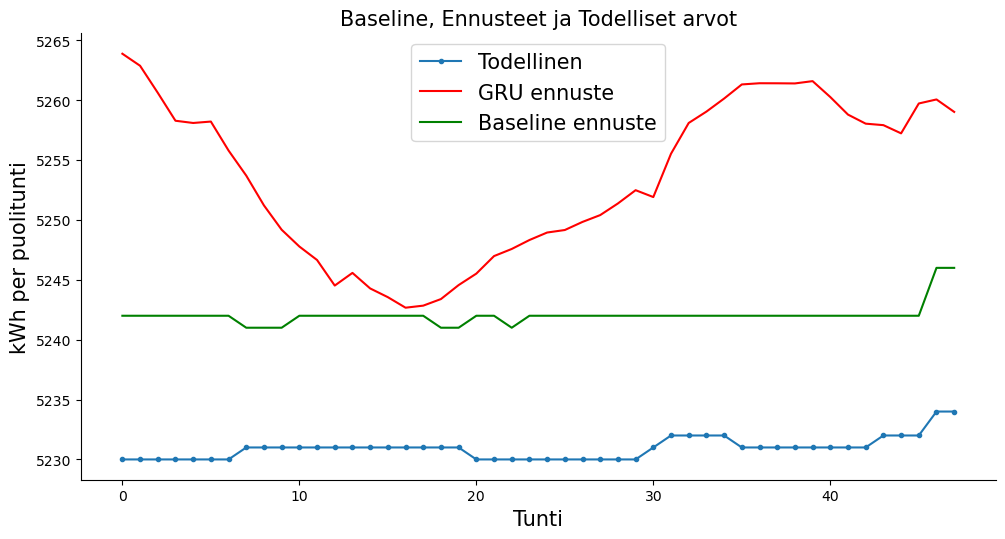

<Figure size 640x480 with 0 Axes>

In [158]:
# laske virhe baseline naive -mallille (normeerattu) testisarjan ensimmäiselle 24 tunnille
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# laske virhe baseline naive -mallille validointisarjalla
valBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size:train_size+OUT_STEPS])

# laske virhe baseline naive -mallille testisarjalla
testBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS])

print('valBaselineMAE: ', valBaselineMAE)
print('testBaselineMAE: ', testBaselineMAE)

len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="todellinen")
plt.plot(len_prediction, mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="Todellinen")
plt.plot(len_prediction, testYhat[0,:,-1], 'r', label="GRU ennuste")
plt.plot(len_prediction, NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 'g', label="Baseline ennuste")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('kWh per puolitunti', size=15)
plt.xlabel('Tunti', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Ennusteet ja Todelliset arvot', size=15)
plt.show()
plt.savefig('Baseline, Ennusteet ja Todelliset arvot.png', format='png')


- Tämä viittaa siihen, että vaikka GRU-malli yrittää ennustaa muutoksia, se ei ole vielä tarkka. Baseline-malli ei tarjoa lisäarvoa ja ennustaa tasaisia arvoja, vaikka todellisuudessa datassa on muutoksia.

- Alla oleva koodi auttaa arvioimaan, kuinka hyvin käytetty malli on verrattuna yksinkertaiseen baseline-malliin ja tarjoaa mittarin mallin suorituskyvyn parannuksesta.

In [159]:
# laske virhe baseline naive -mallille ensimmäiselle 24 tunnille testisarjassa
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# laske virhe baseline naive -mallille testisarjassa
testBaselineMAE1day = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

# laske virhe käytetylle mallille (esim. GRU) testisarjassa
testModelMAE1day = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], testYhat[0,:,-1])

print('testBaselineMAE1day: ', testBaselineMAE1day)
print('testModelMAE1day: ', testModelMAE1day)
print('Mallin tarkkuuden absoluuttinen parannus: ', testBaselineMAE1day - testModelMAE1day)
print('Mallin tarkkuuden prosentuaalinen parannus: ', (testBaselineMAE1day - testModelMAE1day) / testBaselineMAE1day * 100)


testBaselineMAE1day:  11.125
testModelMAE1day:  22.652579677514
Mallin tarkkuuden absoluuttinen parannus:  -11.527579677514002
Mallin tarkkuuden prosentuaalinen parannus:  -103.61869373046292


- Tuloksista nähdään, että käytetty malli (esim. GRU) ei ole parantanut ennusteiden tarkkuutta verrattuna baseline-malliin. Päinvastoin, se on ollut huonompi, ja se on tehnyt ennusteita, jotka poikkeavat todellisista arvoista enemmän kuin baseline. Tämä viittaa siihen, että malli ei ole oppinut hyödyllisiä kaavoja datasta, ja sitä tulisi säätää tai tutkia tarkemmin.

- Alla prosessin avulla saadaan mallin ennusteet, jotka on palautettu alkuperäiseen mittakaavaan ja jotka voidaan verrata todellisiin arvoihin tarkempien virheanalyysien tekemiseksi.

In [160]:
# rakenna datasetti testisarjalle

ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data,
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# ennusteen saaminen
testYhatNormed = multi_gru_model.predict(ds)

print(testYhatNormed.shape)
print(testYhatNormed)

# palautetaan standardointi takaisin
testYhat = testYhatNormed * train_std.AggregateLoad + train_mean.AggregateLoad

print(testYhat.shape)
print(testYhat)


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(7799, 48, 1)
[[[0.7559343 ]
  [0.75543267]
  [0.754306  ]
  ...
  [0.75385946]
  [0.75402755]
  [0.7535083 ]]

 [[0.7417278 ]
  [0.74224454]
  [0.7421242 ]
  ...
  [0.7506445 ]
  [0.75013727]
  [0.74820876]]

 [[0.7408529 ]
  [0.7412431 ]
  [0.7412408 ]
  ...
  [0.74736583]
  [0.74712   ]
  [0.7461256 ]]

 ...

 [[0.66009516]
  [0.6602247 ]
  [0.66119534]
  ...
  [0.6562717 ]
  [0.6563053 ]
  [0.65620327]]

 [[0.6578004 ]
  [0.6581961 ]
  [0.65954965]
  ...
  [0.6576405 ]
  [0.6575486 ]
  [0.6568404 ]]

 [[0.6608968 ]
  [0.6610115 ]
  [0.6621921 ]
  ...
  [0.6592428 ]
  [0.65930414]
  [0.6592614 ]]]
(7799, 48, 1)
[[[5263.88315389]
  [5262.87862618]
  [5260.62249706]
  ...
  [5259.72825733]
  [5260.0648505 ]
  [5259.02511181]]

 [[5235.43446617]
  [5236.46919177]
  [5236.22820538]
  ...
  [5253.29025646]
  [5252.27450898]
  [5248.41263946]]

 [[5233.68239129]
  [5234.4638365 ]
  [5234.45918148]
  ...
  [5246.72466051]
  [5246.23242284]
  [5244.2

- Ennusteet on laskettu ja palautettu alkuperäiseen mittakaavaan, ja ne näyttävät olevan energiankulutuksen arvot puolen tunnin välein.
- Normeeratut ennusteet (testYhatNormed) ovat skaalattu arvot, joita voidaan verrata mallin koulutuksessa käytettyihin normaalisoituihin arvoihin.
- Palautetut ennusteet (testYhat) tarjoavat ennusteet alkuperäisessä mittakaavassa, jotka voidaan vertailla todellisiin energiankulutustietoihin.